### Use Python XGBoost and Optuna hyper parameter tuning to build a REGRESSION model and deploy with KNIME Python nodes


<img src="../KNIME_loves_xgboost_optuna.png" width="600">


##### KNIME workflow
https://hub.knime.com/-/spaces/-/latest/~GABT_OgeoWxWJW9P/


##### MEDIUM Blog: Hyperparameter optimization for LightGBM — wrapped in KNIME nodes

https://medium.com/p/ddb7ae1d7e2

###### Optuna

https://optuna.readthedocs.io/en/stable/index.html

###### additional links and texts

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-better-accuracy

https://stackoverflow.com/questions/67080149/xgboost-error-when-categorical-type-is-supplied-dmatrix-parameter-enable-cat


https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997

https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5


https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

some parameters have been discussed with ChatGPT ....

In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import json
import pickle
import logging

In [49]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, average_precision_score, precision_recall_curve

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import matplotlib.pyplot as plt
import plotly
import matplotlib
import kaleido

In [3]:
# http://strftime.org'
import time
var_timestamp_day = "{}".format(time.strftime("%Y%m%d"))
# flow_variables['var_timestamp_day'] = var_timestamp_day
print("var_timestamp_day: ", var_timestamp_day)

var_timestamp_time = "{}h".format(time.strftime("%H%M"))
# flow_variables['var_timestamp_time'] = var_timestamp_time
print("var_timestamp_time: ", var_timestamp_time)

# _edit: if you want to have another model name
var_model_name = "XGBoost_Optuna_Regression"
# flow_variables['var_model_name'] = var_model_name

var_model_name_full = var_model_name + "_" + var_timestamp_day  + "_" + var_timestamp_time + "_jupyter"
# flow_variables['var_model_name_full'] = var_model_name_full
print("var_model_name_full: ", var_model_name_full)

# if you do not want to store the files in the working directory
var_path_data = "../"
var_path_model = "../model/"

var_timestamp_day:  20240226
var_timestamp_time:  1814h
var_model_name_full:  XGBoost_Optuna_Regression_20240226_1814h_jupyter


The data used has beed adapted from:

**Census Income Data Set**

Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Adult" dataset.

Extract and prepare the Census Income Files for usage in KNIME

https://archive.ics.uci.edu/ml/datasets/census+income

In [4]:
data      = pq.read_table(var_path_data + "dataset_regression_80.parquet").to_pandas()
data_test = pq.read_table(var_path_data + "dataset_regression_20.parquet").to_pandas()

In [5]:
data = data.reset_index(drop=True)

In [6]:
data_test = data_test.reset_index(drop=True)

In [7]:
excluded_features = ['row_id']
label = ['Target']
# features = [feat for feat in data.columns if feat not in excluded_features and not feat==label]
features = [feat for feat in data.columns if feat not in excluded_features and feat not in label]

num_cols = data[features].select_dtypes(include='number').columns.tolist()
cat_cols = data[features].select_dtypes(exclude='number').columns.tolist()

rest_cols = [feat for feat in data.columns if feat not in cat_cols]

print(f'''{"data shape:":20} {data.shape}
{"data[features] shape:":20} {data[features].shape}
categorical columns: {cat_cols}
numerical columns: {num_cols}
feature columns: {features}
rest columns: {rest_cols}''')

# THX David Gutmann 

data shape:          (1183, 80)
data[features] shape: (1183, 79)
categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
numerical columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Tot

In [8]:
print(data.dtypes)

MSSubClass         int32
MSZoning          object
LotFrontage      float64
LotArea            int32
Street            object
                  ...   
MoSold             int32
YrSold             int32
SaleType          object
SaleCondition     object
Target             int32
Length: 80, dtype: object


In [9]:
data[cat_cols] = data[cat_cols].astype('category')

In [10]:
data[label] = data[label].astype('int32')

In [11]:
print(data.dtypes)

MSSubClass          int32
MSZoning         category
LotFrontage       float64
LotArea             int32
Street           category
                   ...   
MoSold              int32
YrSold              int32
SaleType         category
SaleCondition    category
Target              int32
Length: 80, dtype: object


In [12]:
# split training data into X and y
X = data[features]
y = data[label]

In [13]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,0,NA,NA,NA,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,0,NA,NA,NA,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,0,NA,NA,NA,0,12,2008,WD,Normal


In [14]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [15]:
D_train = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
D_test = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [16]:
# y_train = np.ravel(y_train)
# y_test = np.ravel(y_test)

In [17]:
# number of iterations
var_n_boost_round = 200

def objective(trial):
    param = {
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
        # 'scale_pos_weight' is not typically used for regression, so it can be removed.
        'tree_method': trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'objective': 'reg:squarederror',  # Changed to regression objective
        'eval_metric': 'rmse',  # Changed to regression metric
        'min_split_loss': trial.suggest_float('min_split_loss', 1e-8, 1.0),
        'max_bin': trial.suggest_int('max_bin', 64, 512),
        'seed': 42,
        'n_jobs': -1
    }

    # Train model with the given hyperparameters
    model = xgb.train(param, D_train, num_boost_round=var_n_boost_round, evals=[(D_test, 'val')], early_stopping_rounds=25, verbose_eval=50)
    
    # Predict and calculate RMSE score on validation set
    y_val_pred = model.predict(D_test)
    rmse = mean_squared_error(y_test, y_val_pred, squared=False)  # Set 'squared=False' to return RMSE

    return rmse


In [18]:
var_n_trials = var_n_boost_round

# Create Optuna study and optimize the objective function
# Change the direction to 'minimize' since we want to minimize the RMSE
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=var_n_trials)

# Get the best hyperparameters and best RMSE score
best_params = study.best_params
best_score = study.best_value  # This will be the lowest RMSE achieved



[I 2024-02-26 18:14:22,533] A new study created in memory with name: no-name-91d38416-4b7c-407a-9be4-24620ce1296a


[0]	val-rmse:74767.72324
[50]	val-rmse:74764.81632
[100]	val-rmse:74761.87651
[150]	val-rmse:74758.88706
[199]	val-rmse:74756.00971


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:22,856] Trial 0 finished with value: 74756.00909257679 and parameters: {'eta': 0.19648714668066578, 'max_depth': 8, 'subsample': 0.14708843971632, 'colsample_bytree': 0.7667514653065086, 'gamma': 0.6501487826353952, 'alpha': 0.5085306035957922, 'lambda': 0.6629738447656874, 'min_child_weight': 7, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.08599783130645242, 'min_split_loss': 0.6486537249516863, 'max_bin': 382}. Best is trial 0 with value: 74756.00909257679.


[0]	val-rmse:74767.55191
[50]	val-rmse:74756.21854
[100]	val-rmse:74744.89074
[150]	val-rmse:74733.60515
[199]	val-rmse:74722.52352


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:23,275] Trial 1 finished with value: 74722.52313501581 and parameters: {'eta': 0.17735774882467945, 'max_depth': 6, 'subsample': 0.7988130708989958, 'colsample_bytree': 0.7859406774564164, 'gamma': 0.5884584839658196, 'alpha': 0.2187273563357315, 'lambda': 0.21554992239082219, 'min_child_weight': 9, 'max_delta_step': 10, 'tree_method': 'approx', 'learning_rate': 0.03474514333877956, 'min_split_loss': 0.4841713601020599, 'max_bin': 338}. Best is trial 1 with value: 74722.52313501581.


[0]	val-rmse:68111.96569
[50]	val-rmse:22959.55328
[69]	val-rmse:22956.83760


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:23,611] Trial 2 finished with value: 22967.74085349926 and parameters: {'eta': 0.13005638443992906, 'max_depth': 11, 'subsample': 0.8318369678350367, 'colsample_bytree': 0.5962870589599176, 'gamma': 0.6734788547165178, 'alpha': 0.5447781651664765, 'lambda': 0.42527892564469866, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'hist', 'learning_rate': 0.1056100935832633, 'min_split_loss': 0.6671413995642742, 'max_bin': 506}. Best is trial 2 with value: 22967.74085349926.


[0]	val-rmse:74767.50101
[50]	val-rmse:74753.19006
[100]	val-rmse:74738.81326
[150]	val-rmse:74724.46524
[199]	val-rmse:74710.45154


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:23,992] Trial 3 finished with value: 74710.4509678215 and parameters: {'eta': 0.19852445478105926, 'max_depth': 6, 'subsample': 0.5745577887543072, 'colsample_bytree': 0.4135157457088764, 'gamma': 0.6538620435499692, 'alpha': 0.41152942670105835, 'lambda': 0.9014736991860132, 'min_child_weight': 5, 'max_delta_step': 10, 'tree_method': 'hist', 'learning_rate': 0.04369184581926427, 'min_split_loss': 0.6725464512648226, 'max_bin': 509}. Best is trial 2 with value: 22967.74085349926.


[0]	val-rmse:74767.42328
[50]	val-rmse:74746.62423
[100]	val-rmse:74725.56678
[150]	val-rmse:74704.88490
[199]	val-rmse:74684.73412


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:24,421] Trial 4 finished with value: 74684.73400572044 and parameters: {'eta': 0.19976001466106783, 'max_depth': 11, 'subsample': 0.5924386781877365, 'colsample_bytree': 0.11089996869932482, 'gamma': 0.6652433215884211, 'alpha': 0.928114460795241, 'lambda': 0.13086079682302182, 'min_child_weight': 2, 'max_delta_step': 10, 'tree_method': 'auto', 'learning_rate': 0.06957113296117838, 'min_split_loss': 0.3330543060221163, 'max_bin': 349}. Best is trial 2 with value: 22967.74085349926.


[0]	val-rmse:74767.11268
[50]	val-rmse:74733.22118
[100]	val-rmse:74698.76608
[150]	val-rmse:74664.01672
[199]	val-rmse:74631.08849


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:24,688] Trial 5 finished with value: 74631.08774001648 and parameters: {'eta': 0.24221882266540665, 'max_depth': 8, 'subsample': 0.16303263968543538, 'colsample_bytree': 0.16469236233039844, 'gamma': 0.5930034863236493, 'alpha': 0.15390711282651115, 'lambda': 0.24370372698327855, 'min_child_weight': 9, 'max_delta_step': 7, 'tree_method': 'hist', 'learning_rate': 0.1686995103649037, 'min_split_loss': 0.24933265358348325, 'max_bin': 498}. Best is trial 2 with value: 22967.74085349926.


[0]	val-rmse:74767.65753
[50]	val-rmse:74761.92659
[100]	val-rmse:74756.03354
[150]	val-rmse:74750.13378
[199]	val-rmse:74744.52502


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:24,961] Trial 6 finished with value: 74744.52424803807 and parameters: {'eta': 0.019861761303736118, 'max_depth': 7, 'subsample': 0.11797504104911316, 'colsample_bytree': 0.6583935186054103, 'gamma': 0.39993695883225, 'alpha': 0.7874099169012932, 'lambda': 0.8436817698269804, 'min_child_weight': 8, 'max_delta_step': 2, 'tree_method': 'approx', 'learning_rate': 0.0902047588988487, 'min_split_loss': 0.6109378525065361, 'max_bin': 347}. Best is trial 2 with value: 22967.74085349926.


[0]	val-rmse:74767.42376
[50]	val-rmse:74748.39899
[100]	val-rmse:74728.93051
[150]	val-rmse:74709.63210
[199]	val-rmse:74690.66256


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:25,345] Trial 7 finished with value: 74690.66220046113 and parameters: {'eta': 0.1951210204607014, 'max_depth': 12, 'subsample': 0.6934660743217964, 'colsample_bytree': 0.19807112981023126, 'gamma': 0.5413259680811721, 'alpha': 0.61271755494977, 'lambda': 0.8819837453800069, 'min_child_weight': 6, 'max_delta_step': 8, 'tree_method': 'approx', 'learning_rate': 0.07594375721087894, 'min_split_loss': 0.01345534491763697, 'max_bin': 356}. Best is trial 2 with value: 22967.74085349926.


[0]	val-rmse:74767.52462
[50]	val-rmse:74753.37030
[100]	val-rmse:74739.07698
[150]	val-rmse:74724.91692
[199]	val-rmse:74710.95350


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:25,721] Trial 8 finished with value: 74710.95306310264 and parameters: {'eta': 0.043027706892264886, 'max_depth': 9, 'subsample': 0.7476292480682878, 'colsample_bytree': 0.17546588808844069, 'gamma': 0.4995864157017965, 'alpha': 0.8603119408109713, 'lambda': 0.4316299186472551, 'min_child_weight': 9, 'max_delta_step': 3, 'tree_method': 'approx', 'learning_rate': 0.15195331724782812, 'min_split_loss': 0.6577643393344935, 'max_bin': 163}. Best is trial 2 with value: 22967.74085349926.


[0]	val-rmse:74766.87339
[50]	val-rmse:74719.83391
[100]	val-rmse:74672.28426
[150]	val-rmse:74625.21920
[199]	val-rmse:74579.26642


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:26,035] Trial 9 finished with value: 74579.26570553544 and parameters: {'eta': 0.10940643413820537, 'max_depth': 14, 'subsample': 0.33636968920596055, 'colsample_bytree': 0.36631851759993284, 'gamma': 0.07178409586403764, 'alpha': 0.023344063970513147, 'lambda': 0.5595510244178122, 'min_child_weight': 7, 'max_delta_step': 9, 'tree_method': 'hist', 'learning_rate': 0.16543318868841767, 'min_split_loss': 0.6625252287559864, 'max_bin': 68}. Best is trial 2 with value: 22967.74085349926.


[0]	val-rmse:74767.35811
[50]	val-rmse:74746.17543
[100]	val-rmse:74724.90852
[150]	val-rmse:74703.70588
[199]	val-rmse:74682.93423


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:26,923] Trial 10 finished with value: 74682.93359035441 and parameters: {'eta': 0.10808214166993899, 'max_depth': 15, 'subsample': 0.9646353755395036, 'colsample_bytree': 0.9602251509582134, 'gamma': 0.97715961870969, 'alpha': 0.6698912780772805, 'lambda': 0.38881696723414993, 'min_child_weight': 1, 'max_delta_step': 5, 'tree_method': 'exact', 'learning_rate': 0.12884558108299937, 'min_split_loss': 0.993866335127333, 'max_bin': 223}. Best is trial 2 with value: 22967.74085349926.


[0]	val-rmse:74767.27931
[50]	val-rmse:74741.50063
[100]	val-rmse:74715.65180
[150]	val-rmse:74689.66509
[199]	val-rmse:74664.35982


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:27,329] Trial 11 finished with value: 74664.35933141492 and parameters: {'eta': 0.10647194642022045, 'max_depth': 14, 'subsample': 0.35935037679494114, 'colsample_bytree': 0.43350253713406706, 'gamma': 0.051151612067934005, 'alpha': 0.03253775089612008, 'lambda': 0.624917687085012, 'min_child_weight': 3, 'max_delta_step': 4, 'tree_method': 'hist', 'learning_rate': 0.19894955573281653, 'min_split_loss': 0.8613229544355416, 'max_bin': 67}. Best is trial 2 with value: 22967.74085349926.


[0]	val-rmse:66551.72485
[50]	val-rmse:23297.81914
[77]	val-rmse:23903.68392


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:27,675] Trial 12 finished with value: 23903.683969926955 and parameters: {'eta': 0.11636217537501226, 'max_depth': 13, 'subsample': 0.3550353694947028, 'colsample_bytree': 0.443580572448032, 'gamma': 0.06878513199522135, 'alpha': 0.3472539981955292, 'lambda': 0.5774578878683504, 'min_child_weight': 4, 'max_delta_step': 0, 'tree_method': 'hist', 'learning_rate': 0.12892107223526889, 'min_split_loss': 0.8371174983390096, 'max_bin': 110}. Best is trial 2 with value: 22967.74085349926.


[0]	val-rmse:66756.71810
[50]	val-rmse:24762.59681
[100]	val-rmse:24372.75572
[150]	val-rmse:24309.03492
[161]	val-rmse:24309.97829


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:28,341] Trial 13 finished with value: 24309.978270311974 and parameters: {'eta': 0.13842842393205118, 'max_depth': 12, 'subsample': 0.3812956720136897, 'colsample_bytree': 0.5805085251130901, 'gamma': 0.22099575676778405, 'alpha': 0.342675272881106, 'lambda': 0.013706739265490597, 'min_child_weight': 4, 'max_delta_step': 0, 'tree_method': 'hist', 'learning_rate': 0.1228024595948998, 'min_split_loss': 0.8589922167339247, 'max_bin': 216}. Best is trial 2 with value: 22967.74085349926.


[0]	val-rmse:68292.99404
[50]	val-rmse:22626.36964
[95]	val-rmse:22535.26967


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:28,740] Trial 14 finished with value: 22535.26971802079 and parameters: {'eta': 0.06900879872597006, 'max_depth': 10, 'subsample': 0.9906311376299468, 'colsample_bytree': 0.5255381367889496, 'gamma': 0.8467134935070958, 'alpha': 0.3410899555397965, 'lambda': 0.6867859227260855, 'min_child_weight': 4, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.11883025181377624, 'min_split_loss': 0.8372282803358545, 'max_bin': 450}. Best is trial 14 with value: 22535.26971802079.


[0]	val-rmse:74767.63498
[50]	val-rmse:74760.33545
[100]	val-rmse:74753.02804
[150]	val-rmse:74745.74327
[199]	val-rmse:74738.58947


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:29,287] Trial 15 finished with value: 74738.58913763174 and parameters: {'eta': 0.06335790639336211, 'max_depth': 10, 'subsample': 0.9842398170443457, 'colsample_bytree': 0.5788786895391368, 'gamma': 0.8504720594942349, 'alpha': 0.5346552349378104, 'lambda': 0.7344223259940097, 'min_child_weight': 3, 'max_delta_step': 2, 'tree_method': 'exact', 'learning_rate': 0.10977392611492227, 'min_split_loss': 0.49015629815327966, 'max_bin': 445}. Best is trial 14 with value: 22535.26971802079.


[0]	val-rmse:74767.36138
[50]	val-rmse:74746.63772
[100]	val-rmse:74725.91032
[150]	val-rmse:74705.20798
[199]	val-rmse:74684.98154


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:29,979] Trial 16 finished with value: 74684.98104914244 and parameters: {'eta': 0.2886589140103176, 'max_depth': 10, 'subsample': 0.8630071607956732, 'colsample_bytree': 0.7152961563090098, 'gamma': 0.8120557914671135, 'alpha': 0.7265832865080344, 'lambda': 0.4505388107545528, 'min_child_weight': 1, 'max_delta_step': 6, 'tree_method': 'exact', 'learning_rate': 0.10395907415559974, 'min_split_loss': 0.9724012764925125, 'max_bin': 441}. Best is trial 14 with value: 22535.26971802079.


[0]	val-rmse:74767.74132
[50]	val-rmse:74765.64967
[100]	val-rmse:74763.57007
[150]	val-rmse:74761.47834
[199]	val-rmse:74759.43505


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:30,512] Trial 17 finished with value: 74759.43475590766 and parameters: {'eta': 0.07559077261121576, 'max_depth': 11, 'subsample': 0.8855807500555606, 'colsample_bytree': 0.8685198165222696, 'gamma': 0.8221769816383749, 'alpha': 0.2524188073615878, 'lambda': 0.7573197996151972, 'min_child_weight': 5, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.05908141980887112, 'min_split_loss': 0.7791311527064154, 'max_bin': 428}. Best is trial 14 with value: 22535.26971802079.


[0]	val-rmse:74767.47218
[50]	val-rmse:74752.86464
[100]	val-rmse:74738.02671
[150]	val-rmse:74723.16639
[199]	val-rmse:74708.54691


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:31,012] Trial 18 finished with value: 74708.54679781708 and parameters: {'eta': 0.14725122653507444, 'max_depth': 9, 'subsample': 0.8828448398972172, 'colsample_bytree': 0.316763859451001, 'gamma': 0.9631278690750014, 'alpha': 0.4225069592952679, 'lambda': 0.2906953376005593, 'min_child_weight': 3, 'max_delta_step': 3, 'tree_method': 'exact', 'learning_rate': 0.1491534844103319, 'min_split_loss': 0.3397100923711569, 'max_bin': 280}. Best is trial 14 with value: 22535.26971802079.


[0]	val-rmse:68977.67590
[50]	val-rmse:22680.86300
[100]	val-rmse:22607.03726
[110]	val-rmse:22610.48330


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:31,586] Trial 19 finished with value: 22611.550526906452 and parameters: {'eta': 0.014688114916368844, 'max_depth': 12, 'subsample': 0.9987069408622443, 'colsample_bytree': 0.5156034779232554, 'gamma': 0.31763262182547636, 'alpha': 0.536603388527308, 'lambda': 0.9735401779307786, 'min_child_weight': 4, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.10218038213165083, 'min_split_loss': 0.7704616571235356, 'max_bin': 476}. Best is trial 14 with value: 22535.26971802079.


[0]	val-rmse:74767.76250
[50]	val-rmse:74766.77119
[100]	val-rmse:74765.75002
[150]	val-rmse:74764.72655
[199]	val-rmse:74763.73324


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:31,983] Trial 20 finished with value: 74763.73282501481 and parameters: {'eta': 0.024765959655806413, 'max_depth': 12, 'subsample': 0.9482499997274293, 'colsample_bytree': 0.2912529160672801, 'gamma': 0.30426306695313593, 'alpha': 0.12657203507676165, 'lambda': 0.9937643567388028, 'min_child_weight': 6, 'max_delta_step': 2, 'tree_method': 'exact', 'learning_rate': 0.015747192152779144, 'min_split_loss': 0.7876611862291725, 'max_bin': 276}. Best is trial 14 with value: 22535.26971802079.


[0]	val-rmse:69255.09459
[50]	val-rmse:21040.19787
[100]	val-rmse:20915.80987
[112]	val-rmse:21003.59532


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:32,487] Trial 21 finished with value: 21003.595319525033 and parameters: {'eta': 0.07507213015591901, 'max_depth': 11, 'subsample': 0.6770366783351962, 'colsample_bytree': 0.5332064793552462, 'gamma': 0.7493359731683533, 'alpha': 0.578316773142941, 'lambda': 0.9975317053479325, 'min_child_weight': 4, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.10478818060558115, 'min_split_loss': 0.7520291307098093, 'max_bin': 477}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.71852
[50]	val-rmse:74764.63742
[100]	val-rmse:74761.51952
[150]	val-rmse:74758.44671
[199]	val-rmse:74755.43665


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:32,942] Trial 22 finished with value: 74755.43613400451 and parameters: {'eta': 0.07524869137385976, 'max_depth': 13, 'subsample': 0.6362055090729849, 'colsample_bytree': 0.5048255508110786, 'gamma': 0.4062956389654555, 'alpha': 0.6005900340403025, 'lambda': 0.9878914476399143, 'min_child_weight': 4, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.09496150940366549, 'min_split_loss': 0.9134613806336043, 'max_bin': 407}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68119.40663
[50]	val-rmse:23952.75231
[59]	val-rmse:24282.89986


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:33,184] Trial 23 finished with value: 24282.899934128145 and parameters: {'eta': 0.049909179322585026, 'max_depth': 10, 'subsample': 0.4392903287156819, 'colsample_bytree': 0.5167298559565895, 'gamma': 0.758312139788363, 'alpha': 0.4357995429033349, 'lambda': 0.7988761208533914, 'min_child_weight': 5, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.12123393422487881, 'min_split_loss': 0.7660923223217023, 'max_bin': 467}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.68896
[50]	val-rmse:74763.09984
[100]	val-rmse:74758.47056
[150]	val-rmse:74753.85793
[199]	val-rmse:74749.33374


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:33,663] Trial 24 finished with value: 74749.33334957772 and parameters: {'eta': 0.0854961037070432, 'max_depth': 13, 'subsample': 0.4849033690055545, 'colsample_bytree': 0.5000689187420544, 'gamma': 0.19381836712585915, 'alpha': 0.3241557984609215, 'lambda': 0.9532843927530222, 'min_child_weight': 2, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.139471172935622, 'min_split_loss': 0.5595472576678617, 'max_bin': 469}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.66725
[50]	val-rmse:74761.95395
[100]	val-rmse:74756.22831
[150]	val-rmse:74750.52988
[199]	val-rmse:74744.96846


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:34,133] Trial 25 finished with value: 74744.96792683797 and parameters: {'eta': 0.015602212605081288, 'max_depth': 9, 'subsample': 0.729320776101469, 'colsample_bytree': 0.6393888455799293, 'gamma': 0.9018068987883984, 'alpha': 0.692027593257655, 'lambda': 0.7038411534868145, 'min_child_weight': 4, 'max_delta_step': 3, 'tree_method': 'exact', 'learning_rate': 0.058011565579633745, 'min_split_loss': 0.7625380063181241, 'max_bin': 391}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68379.95510
[50]	val-rmse:24127.79596
[100]	val-rmse:24042.55650
[102]	val-rmse:24042.31125


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:34,818] Trial 26 finished with value: 24045.01196876317 and parameters: {'eta': 0.044330551580248415, 'max_depth': 12, 'subsample': 0.9223900564903746, 'colsample_bytree': 0.6732417882411461, 'gamma': 0.7483331609277372, 'alpha': 0.4713375778095578, 'lambda': 0.8247876199984828, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.10953508928837764, 'min_split_loss': 0.9307218935407783, 'max_bin': 471}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.59630
[50]	val-rmse:74757.80792
[100]	val-rmse:74747.76208
[150]	val-rmse:74737.62132
[199]	val-rmse:74727.76504


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:35,175] Trial 27 finished with value: 74727.76452775729 and parameters: {'eta': 0.010029961061628359, 'max_depth': 11, 'subsample': 0.7970842588676634, 'colsample_bytree': 0.27585818277600727, 'gamma': 0.41386755008204795, 'alpha': 0.5843621478375864, 'lambda': 0.939343571415645, 'min_child_weight': 6, 'max_delta_step': 4, 'tree_method': 'exact', 'learning_rate': 0.07791934761800925, 'min_split_loss': 0.551208816007716, 'max_bin': 414}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.54805
[50]	val-rmse:74755.04016
[100]	val-rmse:74742.48013
[150]	val-rmse:74729.87062
[199]	val-rmse:74717.66416


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:35,649] Trial 28 finished with value: 74717.6633702519 and parameters: {'eta': 0.037644713954384165, 'max_depth': 10, 'subsample': 0.9939441563783968, 'colsample_bytree': 0.46456972219608933, 'gamma': 0.29653565046910757, 'alpha': 0.7668008214053796, 'lambda': 0.8748367733391113, 'min_child_weight': 5, 'max_delta_step': 2, 'tree_method': 'auto', 'learning_rate': 0.1837367751492151, 'min_split_loss': 0.7404904580581753, 'max_bin': 475}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.72156
[50]	val-rmse:74764.71705
[100]	val-rmse:74761.69547
[150]	val-rmse:74758.69632
[199]	val-rmse:74755.78550


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:35,967] Trial 29 finished with value: 74755.78504034679 and parameters: {'eta': 0.09180372565034459, 'max_depth': 8, 'subsample': 0.22378095024322397, 'colsample_bytree': 0.7351239767739632, 'gamma': 0.733745672082723, 'alpha': 0.4925933973395613, 'lambda': 0.6888430561700961, 'min_child_weight': 7, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.08919422471829572, 'min_split_loss': 0.40082580923333744, 'max_bin': 303}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.68811
[50]	val-rmse:74763.01354
[100]	val-rmse:74758.37066
[150]	val-rmse:74753.72729
[199]	val-rmse:74749.20175


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:36,459] Trial 30 finished with value: 74749.20128486112 and parameters: {'eta': 0.055237143629767976, 'max_depth': 9, 'subsample': 0.6440590996885768, 'colsample_bytree': 0.7864561351200022, 'gamma': 0.9160900254355157, 'alpha': 0.286225703097692, 'lambda': 0.7883552360202166, 'min_child_weight': 4, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.1438599238084061, 'min_split_loss': 0.8923151522580155, 'max_bin': 381}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68535.90505
[50]	val-rmse:23355.92282
[82]	val-rmse:23399.45672


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:36,848] Trial 31 finished with value: 23399.456731474736 and parameters: {'eta': 0.13390837406591843, 'max_depth': 11, 'subsample': 0.8278322922065608, 'colsample_bytree': 0.570914105138793, 'gamma': 0.6859935634985546, 'alpha': 0.5351433240122204, 'lambda': 0.6360928423525378, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'hist', 'learning_rate': 0.10076222953817766, 'min_split_loss': 0.7114841645128289, 'max_bin': 505}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:67957.97366
[50]	val-rmse:22609.55964
[96]	val-rmse:22565.21484


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:37,351] Trial 32 finished with value: 22562.19541734405 and parameters: {'eta': 0.16242510409687527, 'max_depth': 11, 'subsample': 0.8072112690216167, 'colsample_bytree': 0.5871696941174676, 'gamma': 0.5937716359587942, 'alpha': 0.6372383598151288, 'lambda': 0.36089521625400084, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.11951618210000411, 'min_split_loss': 0.5908952783133137, 'max_bin': 456}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:65873.65264
[50]	val-rmse:22605.93436
[100]	val-rmse:22521.32045
[133]	val-rmse:22519.05587


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:38,102] Trial 33 finished with value: 22519.055811282575 and parameters: {'eta': 0.22535204710104031, 'max_depth': 12, 'subsample': 0.7738388290734133, 'colsample_bytree': 0.36907229550154996, 'gamma': 0.5016364507543358, 'alpha': 0.6201584894449368, 'lambda': 0.31404657952225257, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.13591664835844058, 'min_split_loss': 0.5964936147437421, 'max_bin': 446}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.68733
[50]	val-rmse:74763.14693
[100]	val-rmse:74758.52427
[150]	val-rmse:74753.90627
[199]	val-rmse:74749.35526


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:38,683] Trial 34 finished with value: 74749.3547338244 and parameters: {'eta': 0.1776159548735035, 'max_depth': 11, 'subsample': 0.7706558348018532, 'colsample_bytree': 0.3696347717218763, 'gamma': 0.601830500327686, 'alpha': 0.6649067508494215, 'lambda': 0.33955556001572035, 'min_child_weight': 2, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.1354525638631206, 'min_split_loss': 0.5878532316430969, 'max_bin': 378}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.57155
[50]	val-rmse:74757.55016
[100]	val-rmse:74747.37141
[150]	val-rmse:74737.13488
[199]	val-rmse:74727.22375


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:39,308] Trial 35 finished with value: 74727.22323168571 and parameters: {'eta': 0.24351526186071726, 'max_depth': 10, 'subsample': 0.6757283672268822, 'colsample_bytree': 0.3732764146843677, 'gamma': 0.5345622794430699, 'alpha': 0.84015050076313, 'lambda': 0.15510332143299932, 'min_child_weight': 1, 'max_delta_step': 2, 'tree_method': 'exact', 'learning_rate': 0.16004462336509728, 'min_split_loss': 0.6999012138581556, 'max_bin': 443}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:67859.38379
[50]	val-rmse:22453.25240
[71]	val-rmse:22547.56205


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:39,681] Trial 36 finished with value: 22547.562014960295 and parameters: {'eta': 0.16388379368200587, 'max_depth': 13, 'subsample': 0.5685419665130357, 'colsample_bytree': 0.6213152929072828, 'gamma': 0.4797011704433134, 'alpha': 0.39659197640902527, 'lambda': 0.5401417502228589, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.12103047468403504, 'min_split_loss': 0.46687078628767664, 'max_bin': 316}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68737.69261
[50]	val-rmse:25213.60584
[100]	val-rmse:24839.43366
[126]	val-rmse:24902.44205


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:40,402] Trial 37 finished with value: 24878.15995992387 and parameters: {'eta': 0.2347943878811879, 'max_depth': 14, 'subsample': 0.5221670999366552, 'colsample_bytree': 0.7923180298878526, 'gamma': 0.4690349294773042, 'alpha': 0.3665788307625828, 'lambda': 0.5099727389276759, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.11590156238941768, 'min_split_loss': 0.41615392611608604, 'max_bin': 409}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.67800
[50]	val-rmse:74762.54571
[100]	val-rmse:74757.36398
[150]	val-rmse:74752.20688
[199]	val-rmse:74747.17274


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:40,981] Trial 38 finished with value: 74747.17227515198 and parameters: {'eta': 0.22240793913053503, 'max_depth': 13, 'subsample': 0.5612877591950948, 'colsample_bytree': 0.6266772037585435, 'gamma': 0.6991528190164673, 'alpha': 0.21213527269473476, 'lambda': 0.522716668114162, 'min_child_weight': 2, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.15587289469761015, 'min_split_loss': 0.45099369303060644, 'max_bin': 303}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.66905
[50]	val-rmse:74761.97068
[100]	val-rmse:74756.24981
[150]	val-rmse:74750.54680
[199]	val-rmse:74744.96058


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:41,461] Trial 39 finished with value: 74744.96001216365 and parameters: {'eta': 0.27963920803995396, 'max_depth': 15, 'subsample': 0.7046071342512766, 'colsample_bytree': 0.7026719113270177, 'gamma': 0.6357281408855725, 'alpha': 0.4005118277782625, 'lambda': 0.21934861322371313, 'min_child_weight': 5, 'max_delta_step': 2, 'tree_method': 'auto', 'learning_rate': 0.08284987320842357, 'min_split_loss': 0.1828518187656632, 'max_bin': 329}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.47838
[50]	val-rmse:74750.41653
[100]	val-rmse:74733.13686
[150]	val-rmse:74716.30612
[199]	val-rmse:74699.73388


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:41,948] Trial 40 finished with value: 74699.73348685815 and parameters: {'eta': 0.1656315359636476, 'max_depth': 13, 'subsample': 0.6253073020299598, 'colsample_bytree': 0.2393995680048938, 'gamma': 0.4541751744220474, 'alpha': 0.9489147398337303, 'lambda': 0.4684425554398376, 'min_child_weight': 3, 'max_delta_step': 4, 'tree_method': 'approx', 'learning_rate': 0.13304345870503514, 'min_split_loss': 0.5323920050359837, 'max_bin': 496}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:67421.12884
[50]	val-rmse:23487.27256
[94]	val-rmse:23398.95174


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:42,369] Trial 41 finished with value: 23398.951724460407 and parameters: {'eta': 0.16281361922389176, 'max_depth': 11, 'subsample': 0.8000585427791634, 'colsample_bytree': 0.6033859714453211, 'gamma': 0.5613509366854909, 'alpha': 0.6258623256888419, 'lambda': 0.3450192626295085, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.11622984545982139, 'min_split_loss': 0.6250042547142397, 'max_bin': 254}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68019.26990
[50]	val-rmse:21961.51552
[70]	val-rmse:22218.42758


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:42,746] Trial 42 finished with value: 22235.76336198417 and parameters: {'eta': 0.18358566510607424, 'max_depth': 12, 'subsample': 0.5839638550396421, 'colsample_bytree': 0.5341737460609917, 'gamma': 0.6153522436401422, 'alpha': 0.4720303101576824, 'lambda': 0.3099487382514271, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.12349457474616723, 'min_split_loss': 0.6143587191896995, 'max_bin': 449}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.66527
[50]	val-rmse:74762.05244
[100]	val-rmse:74756.38095
[150]	val-rmse:74750.69463
[199]	val-rmse:74745.18848


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:43,442] Trial 43 finished with value: 74745.18792544541 and parameters: {'eta': 0.21000733696637497, 'max_depth': 12, 'subsample': 0.5918665160023197, 'colsample_bytree': 0.5366440009373558, 'gamma': 0.7815364926114076, 'alpha': 0.4597076119865274, 'lambda': 0.13958929599144543, 'min_child_weight': 2, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.1751213656169572, 'min_split_loss': 0.49896782064677514, 'max_bin': 361}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.13447
[50]	val-rmse:74734.66948
[100]	val-rmse:74701.74418
[150]	val-rmse:74668.85369
[199]	val-rmse:74636.92979


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:43,863] Trial 44 finished with value: 74636.92927717614 and parameters: {'eta': 0.1888220847418352, 'max_depth': 14, 'subsample': 0.5275085027551674, 'colsample_bytree': 0.40898551938871075, 'gamma': 0.6370129501417451, 'alpha': 0.3929348817497857, 'lambda': 0.5826434521912562, 'min_child_weight': 4, 'max_delta_step': 7, 'tree_method': 'auto', 'learning_rate': 0.14358661230969338, 'min_split_loss': 0.8173946327561696, 'max_bin': 492}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.70160
[50]	val-rmse:74763.67053
[100]	val-rmse:74759.57110
[150]	val-rmse:74755.50205
[199]	val-rmse:74751.53918


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:44,469] Trial 45 finished with value: 74751.5388011878 and parameters: {'eta': 0.25924849971898656, 'max_depth': 12, 'subsample': 0.44209814956314103, 'colsample_bytree': 0.48020673897300115, 'gamma': 0.4926965519701207, 'alpha': 0.2983150579360143, 'lambda': 0.2816502065997818, 'min_child_weight': 1, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.1247736738849901, 'min_split_loss': 0.6535235173619367, 'max_bin': 177}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.59019
[50]	val-rmse:74758.54124
[100]	val-rmse:74749.34853
[150]	val-rmse:74740.19614
[199]	val-rmse:74731.26090


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:44,848] Trial 46 finished with value: 74731.26058780235 and parameters: {'eta': 0.2081209014289926, 'max_depth': 6, 'subsample': 0.6631475719052378, 'colsample_bytree': 0.40729039896917035, 'gamma': 0.87143523130969, 'alpha': 0.49714749848962836, 'lambda': 0.3951885702900986, 'min_child_weight': 10, 'max_delta_step': 3, 'tree_method': 'exact', 'learning_rate': 0.09485739379421235, 'min_split_loss': 0.35288053087304094, 'max_bin': 424}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68226.02548
[50]	val-rmse:24441.90762
[65]	val-rmse:24171.99344


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:45,240] Trial 47 finished with value: 24171.993466948275 and parameters: {'eta': 0.18231646960109424, 'max_depth': 13, 'subsample': 0.6044708621687394, 'colsample_bytree': 0.66272283396351, 'gamma': 0.5493012772007082, 'alpha': 0.5710027551357194, 'lambda': 0.0007232639436581256, 'min_child_weight': 5, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.11266792154059892, 'min_split_loss': 0.26984058435504, 'max_bin': 334}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:67007.33970
[50]	val-rmse:24075.02123
[70]	val-rmse:24003.98559


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:45,471] Trial 48 finished with value: 24003.985560201276 and parameters: {'eta': 0.11723619650234042, 'max_depth': 7, 'subsample': 0.7318001290313204, 'colsample_bytree': 0.5555152051948455, 'gamma': 0.7022132298483167, 'alpha': 0.17703828895801907, 'lambda': 0.268489966307348, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.13132804903231737, 'min_split_loss': 0.7034090626445709, 'max_bin': 436}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74766.89153
[50]	val-rmse:74724.89719
[100]	val-rmse:74681.91993
[150]	val-rmse:74638.71539
[199]	val-rmse:74596.83382


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:45,852] Trial 49 finished with value: 74596.83369121946 and parameters: {'eta': 0.14647054684074048, 'max_depth': 12, 'subsample': 0.49683155192152173, 'colsample_bytree': 0.33783726819442106, 'gamma': 0.3477731762646799, 'alpha': 0.722382483533291, 'lambda': 0.6207432178199748, 'min_child_weight': 4, 'max_delta_step': 9, 'tree_method': 'exact', 'learning_rate': 0.14788576069039466, 'min_split_loss': 0.4503221872399135, 'max_bin': 394}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.66122
[50]	val-rmse:74761.59982
[100]	val-rmse:74755.51752
[150]	val-rmse:74749.41762
[199]	val-rmse:74743.44917


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:46,247] Trial 50 finished with value: 74743.4483762135 and parameters: {'eta': 0.2268365058159488, 'max_depth': 13, 'subsample': 0.2877707555669509, 'colsample_bytree': 0.6114828624388364, 'gamma': 0.8071247094703717, 'alpha': 0.44988612784683113, 'lambda': 0.19164970828276998, 'min_child_weight': 3, 'max_delta_step': 2, 'tree_method': 'exact', 'learning_rate': 0.0972416387912051, 'min_split_loss': 0.0067676114037970025, 'max_bin': 483}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68145.48292
[50]	val-rmse:24132.25518
[84]	val-rmse:24096.72470


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:46,683] Trial 51 finished with value: 24091.640128778185 and parameters: {'eta': 0.1611049638700091, 'max_depth': 11, 'subsample': 0.837886238402645, 'colsample_bytree': 0.4513745178397559, 'gamma': 0.6150313252046429, 'alpha': 0.6667677806031412, 'lambda': 0.33380655466184606, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.12045408400256793, 'min_split_loss': 0.6075903024617662, 'max_bin': 462}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68734.81168
[50]	val-rmse:23095.11006
[100]	val-rmse:22972.62147
[128]	val-rmse:22976.13717


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:47,380] Trial 52 finished with value: 22976.137070935416 and parameters: {'eta': 0.1740944985474899, 'max_depth': 11, 'subsample': 0.7780681058378849, 'colsample_bytree': 0.5501680323438017, 'gamma': 0.5748510503152043, 'alpha': 0.6463553948220161, 'lambda': 0.3768518940261818, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.1079892758579655, 'min_split_loss': 0.5423448093418254, 'max_bin': 455}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.69816
[50]	val-rmse:74763.54521
[100]	val-rmse:74759.35606
[150]	val-rmse:74755.19416
[199]	val-rmse:74751.12873


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:47,908] Trial 53 finished with value: 74751.12846347647 and parameters: {'eta': 0.2057043980777716, 'max_depth': 10, 'subsample': 0.9126988413965529, 'colsample_bytree': 0.5906156528766922, 'gamma': 0.514675376582839, 'alpha': 0.5672184790525074, 'lambda': 0.4587701514320108, 'min_child_weight': 4, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.12586470310062187, 'min_split_loss': 0.582389474345909, 'max_bin': 428}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68474.04442
[50]	val-rmse:24432.32878
[87]	val-rmse:24445.26455


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:48,390] Trial 54 finished with value: 24459.9639577642 and parameters: {'eta': 0.1240895936080122, 'max_depth': 12, 'subsample': 0.7025829076861401, 'colsample_bytree': 0.4803810383479899, 'gamma': 0.45217292779633667, 'alpha': 0.6191248659860286, 'lambda': 0.4095517655427908, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.11673166763691326, 'min_split_loss': 0.6372667500894607, 'max_bin': 508}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.68718
[50]	val-rmse:74763.03800
[100]	val-rmse:74758.38842
[150]	val-rmse:74753.69870
[199]	val-rmse:74749.14962


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:48,977] Trial 55 finished with value: 74749.14918685381 and parameters: {'eta': 0.19238102227248266, 'max_depth': 10, 'subsample': 0.5737484027044922, 'colsample_bytree': 0.6929439062714748, 'gamma': 0.6765392710773087, 'alpha': 0.5120311061926319, 'lambda': 0.3138172286718199, 'min_child_weight': 3, 'max_delta_step': 1, 'tree_method': 'hist', 'learning_rate': 0.14057034146509556, 'min_split_loss': 0.8222961999456158, 'max_bin': 453}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:65975.91547
[50]	val-rmse:24301.32958
[89]	val-rmse:24279.93478


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:49,517] Trial 56 finished with value: 24281.558442569567 and parameters: {'eta': 0.1503327074542469, 'max_depth': 9, 'subsample': 0.8462756416727579, 'colsample_bytree': 0.7488813321295025, 'gamma': 0.3599180277747922, 'alpha': 0.38419433568947947, 'lambda': 0.06642326974725299, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.1364193568590211, 'min_split_loss': 0.6786022747303124, 'max_bin': 489}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.50777
[50]	val-rmse:74754.19817
[100]	val-rmse:74740.82428
[150]	val-rmse:74727.56478
[199]	val-rmse:74714.55338


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:49,917] Trial 57 finished with value: 74714.55281295809 and parameters: {'eta': 0.25761229163057797, 'max_depth': 11, 'subsample': 0.4559379370436042, 'colsample_bytree': 0.5358167181893899, 'gamma': 0.9968521710924234, 'alpha': 0.7746211493014231, 'lambda': 0.24380283226603477, 'min_child_weight': 4, 'max_delta_step': 6, 'tree_method': 'exact', 'learning_rate': 0.06766949015509247, 'min_split_loss': 0.5170272050148758, 'max_bin': 370}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.70836
[50]	val-rmse:74764.07696
[100]	val-rmse:74760.44567
[150]	val-rmse:74756.78519
[199]	val-rmse:74753.23930


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:50,493] Trial 58 finished with value: 74753.23854469394 and parameters: {'eta': 0.09865503390914046, 'max_depth': 14, 'subsample': 0.7370776931341994, 'colsample_bytree': 0.6446486318131597, 'gamma': 0.5916349812108547, 'alpha': 0.7270835286679278, 'lambda': 0.5522423541913678, 'min_child_weight': 2, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.10920874297323876, 'min_split_loss': 0.7233177491836225, 'max_bin': 132}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68275.77918
[50]	val-rmse:26054.35657
[61]	val-rmse:25873.27032


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:50,778] Trial 59 finished with value: 25873.27029005195 and parameters: {'eta': 0.06961778994739602, 'max_depth': 12, 'subsample': 0.6113269327576533, 'colsample_bytree': 0.8232256275579569, 'gamma': 0.7311869074233076, 'alpha': 0.24288411164516954, 'lambda': 0.3634098530777753, 'min_child_weight': 5, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.12516335582368263, 'min_split_loss': 0.4812080966509469, 'max_bin': 233}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.57318
[50]	val-rmse:74757.32211
[100]	val-rmse:74746.93043
[150]	val-rmse:74736.61945
[199]	val-rmse:74726.49227


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:51,282] Trial 60 finished with value: 74726.49175761278 and parameters: {'eta': 0.1425691475904823, 'max_depth': 12, 'subsample': 0.9395376995986262, 'colsample_bytree': 0.4281535914547623, 'gamma': 0.426722238588109, 'alpha': 0.3265152182942501, 'lambda': 0.48158264141256973, 'min_child_weight': 4, 'max_delta_step': 2, 'tree_method': 'exact', 'learning_rate': 0.1535094984157903, 'min_split_loss': 0.865051226071986, 'max_bin': 402}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:69010.36196
[50]	val-rmse:22924.73654
[95]	val-rmse:22888.75429


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:51,769] Trial 61 finished with value: 22888.754347083395 and parameters: {'eta': 0.027148483402470953, 'max_depth': 12, 'subsample': 0.9020406385541139, 'colsample_bytree': 0.5190346111841021, 'gamma': 0.23973481927824242, 'alpha': 0.5494280453702821, 'lambda': 0.9152776495963763, 'min_child_weight': 4, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.10497761684912867, 'min_split_loss': 0.780770719559004, 'max_bin': 479}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:69851.32424
[50]	val-rmse:22669.98579
[100]	val-rmse:22399.85604
[150]	val-rmse:22361.59018
[164]	val-rmse:22359.09963


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:52,761] Trial 62 finished with value: 22359.099620657682 and parameters: {'eta': 0.12529213874516076, 'max_depth': 13, 'subsample': 0.9728940671411938, 'colsample_bytree': 0.4964379932294334, 'gamma': 0.13140815808228662, 'alpha': 0.5317636162067735, 'lambda': 0.9531136461799298, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.09156724114695013, 'min_split_loss': 0.5879199065209245, 'max_bin': 512}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:69913.67475
[50]	val-rmse:22942.64126
[100]	val-rmse:22717.01740
[135]	val-rmse:22701.34945


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:53,574] Trial 63 finished with value: 22701.349414645305 and parameters: {'eta': 0.08268174820485052, 'max_depth': 13, 'subsample': 0.967017941427745, 'colsample_bytree': 0.5792579226068353, 'gamma': 0.1380279466072596, 'alpha': 0.48654745241563685, 'lambda': 0.8875587131281699, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.09172346666059283, 'min_split_loss': 0.5916265904625888, 'max_bin': 511}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.72017
[50]	val-rmse:74764.63767
[100]	val-rmse:74761.51055
[150]	val-rmse:74758.39996
[199]	val-rmse:74755.36281


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:54,171] Trial 64 finished with value: 74755.36222255872 and parameters: {'eta': 0.06205715552751841, 'max_depth': 14, 'subsample': 0.8750040959206911, 'colsample_bytree': 0.47558874082929214, 'gamma': 0.1147963501516358, 'alpha': 0.4207964682564661, 'lambda': 0.4333063062426762, 'min_child_weight': 2, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.08716260679609328, 'min_split_loss': 0.6619039562904176, 'max_bin': 444}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:69292.27243
[50]	val-rmse:24068.52739
[100]	val-rmse:23838.05354
[150]	val-rmse:23764.12588
[168]	val-rmse:23756.62604


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:54,975] Trial 65 finished with value: 23756.626087730445 and parameters: {'eta': 0.12701448184829364, 'max_depth': 11, 'subsample': 0.8189490777277721, 'colsample_bytree': 0.625111659205518, 'gamma': 0.8504343907652416, 'alpha': 0.601110911608777, 'lambda': 0.862249546228012, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.09913410941625467, 'min_split_loss': 0.5732099008993028, 'max_bin': 458}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.73318
[50]	val-rmse:74765.11716
[100]	val-rmse:74762.51874
[150]	val-rmse:74759.91133
[199]	val-rmse:74757.36193


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:55,504] Trial 66 finished with value: 74757.3615615684 and parameters: {'eta': 0.10141133597145625, 'max_depth': 10, 'subsample': 0.9416689522677352, 'colsample_bytree': 0.5047596578388694, 'gamma': 0.03285941253299825, 'alpha': 0.5164536983386028, 'lambda': 0.9336453525939893, 'min_child_weight': 4, 'max_delta_step': 1, 'tree_method': 'hist', 'learning_rate': 0.08140133316873624, 'min_split_loss': 0.9581330629122599, 'max_bin': 417}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68320.14109
[50]	val-rmse:21375.28143
[100]	val-rmse:21158.21776
[132]	val-rmse:21162.85973


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:56,222] Trial 67 finished with value: 21162.859787986577 and parameters: {'eta': 0.16581962387672333, 'max_depth': 13, 'subsample': 0.6689547953694961, 'colsample_bytree': 0.5537718661755837, 'gamma': 0.781047573180377, 'alpha': 0.3516649405136145, 'lambda': 0.7479331547819282, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.12037305060145083, 'min_split_loss': 0.4590832002989724, 'max_bin': 491}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.72835
[50]	val-rmse:74765.16754
[100]	val-rmse:74762.58708
[150]	val-rmse:74760.02516
[199]	val-rmse:74757.52725


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:56,865] Trial 68 finished with value: 74757.52716764255 and parameters: {'eta': 0.17109187533047202, 'max_depth': 13, 'subsample': 0.6662433741195697, 'colsample_bytree': 0.3846444030659967, 'gamma': 0.9339419365930669, 'alpha': 0.28827717757130367, 'lambda': 0.6841299998699137, 'min_child_weight': 2, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.0704361324939192, 'min_split_loss': 0.3935539253891662, 'max_bin': 481}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:67761.26520
[50]	val-rmse:23724.76627
[68]	val-rmse:23655.84680


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:57,171] Trial 69 finished with value: 23655.846841525217 and parameters: {'eta': 0.1990933629347987, 'max_depth': 13, 'subsample': 0.5500160294210136, 'colsample_bytree': 0.3285570250092933, 'gamma': 0.7809885604131066, 'alpha': 0.3655253418005407, 'lambda': 0.8266379292180465, 'min_child_weight': 8, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.13024941816113217, 'min_split_loss': 0.4659188518923954, 'max_bin': 496}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.73080
[50]	val-rmse:74764.62141
[100]	val-rmse:74761.40095
[150]	val-rmse:74758.06469
[199]	val-rmse:74754.80838


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:57,687] Trial 70 finished with value: 74754.80805643064 and parameters: {'eta': 0.15256640186090542, 'max_depth': 13, 'subsample': 0.6890273180313405, 'colsample_bytree': 0.13832662968318293, 'gamma': 0.8709993615394325, 'alpha': 0.07898753133604908, 'lambda': 0.7445467917323725, 'min_child_weight': 1, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.11279036998137626, 'min_split_loss': 0.42422971573903556, 'max_bin': 512}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68471.49567
[50]	val-rmse:22598.85291
[87]	val-rmse:22452.27869


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:58,167] Trial 71 finished with value: 22461.339852319332 and parameters: {'eta': 0.18623511290633016, 'max_depth': 12, 'subsample': 0.7616191495755611, 'colsample_bytree': 0.5407211651155093, 'gamma': 0.7811713868081703, 'alpha': 0.4633947706698766, 'lambda': 0.776882815163455, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.1197457574323206, 'min_split_loss': 0.5025487109857518, 'max_bin': 469}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:69087.85920
[50]	val-rmse:22855.06747
[86]	val-rmse:22818.39787


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:58,655] Trial 72 finished with value: 22818.39785872255 and parameters: {'eta': 0.18770409311133085, 'max_depth': 12, 'subsample': 0.7679653214280062, 'colsample_bytree': 0.5565152353398249, 'gamma': 0.8299160030717657, 'alpha': 0.43251236762479783, 'lambda': 0.7278274313686914, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.10493023538017802, 'min_split_loss': 0.36987789041344854, 'max_bin': 466}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:67973.78029
[50]	val-rmse:22474.70496
[81]	val-rmse:22465.24412


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:59,202] Trial 73 finished with value: 22465.244170646554 and parameters: {'eta': 0.1369066043768322, 'max_depth': 14, 'subsample': 0.6445934227610005, 'colsample_bytree': 0.44820342392689605, 'gamma': 0.781963431721684, 'alpha': 0.47414893251597, 'lambda': 0.782579219132689, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.12134724361225072, 'min_split_loss': 0.31363805623162266, 'max_bin': 433}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:67762.33758
[50]	val-rmse:24409.27133
[100]	val-rmse:24365.13349
[103]	val-rmse:24365.95258


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:14:59,869] Trial 74 finished with value: 24365.952696592965 and parameters: {'eta': 0.11728619618006582, 'max_depth': 14, 'subsample': 0.6553721854810457, 'colsample_bytree': 0.44919615925741885, 'gamma': 0.7854550084273069, 'alpha': 0.47227697762461934, 'lambda': 0.7923341055464599, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.13651529115690794, 'min_split_loss': 0.17893558844146557, 'max_bin': 435}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.75013
[50]	val-rmse:74766.22908
[100]	val-rmse:74764.67992
[150]	val-rmse:74763.13380
[199]	val-rmse:74761.62953


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:00,401] Trial 75 finished with value: 74761.62892980022 and parameters: {'eta': 0.13785521770633938, 'max_depth': 15, 'subsample': 0.7085563366360781, 'colsample_bytree': 0.4224237474182652, 'gamma': 0.7480948459528639, 'alpha': 0.5519917193901548, 'lambda': 0.9649688993718039, 'min_child_weight': 2, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.039346636279747715, 'min_split_loss': 0.07469930385116319, 'max_bin': 470}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:67781.77561
[50]	val-rmse:23475.98843
[72]	val-rmse:23521.71072


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:00,789] Trial 76 finished with value: 23486.584356028412 and parameters: {'eta': 0.22202509949046698, 'max_depth': 12, 'subsample': 0.6304806701944057, 'colsample_bytree': 0.49597829532033083, 'gamma': 0.716906542959912, 'alpha': 0.5182121089522718, 'lambda': 0.6515874310040085, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.1293723721180764, 'min_split_loss': 0.30183166576223946, 'max_bin': 495}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.70687
[50]	val-rmse:74764.11072
[100]	val-rmse:74760.47604
[150]	val-rmse:74756.86147
[199]	val-rmse:74753.33544


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:01,264] Trial 77 finished with value: 74753.33465119693 and parameters: {'eta': 0.035719717304682555, 'max_depth': 15, 'subsample': 0.721844942801509, 'colsample_bytree': 0.5300574604639123, 'gamma': 0.8928707994297109, 'alpha': 0.3528429718941736, 'lambda': 0.7741234198132055, 'min_child_weight': 4, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.11424960460830566, 'min_split_loss': 0.7388411995153451, 'max_bin': 445}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.75063
[50]	val-rmse:74766.22763
[100]	val-rmse:74764.67199
[150]	val-rmse:74763.12556
[199]	val-rmse:74761.61700


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:01,775] Trial 78 finished with value: 74761.61646934177 and parameters: {'eta': 0.18125228650799977, 'max_depth': 14, 'subsample': 0.7597913952156621, 'colsample_bytree': 0.45736582262817393, 'gamma': 0.7655260914596173, 'alpha': 0.5924850783780446, 'lambda': 0.847190335826352, 'min_child_weight': 2, 'max_delta_step': 2, 'tree_method': 'exact', 'learning_rate': 0.02434411681126332, 'min_split_loss': 0.5143170242986748, 'max_bin': 486}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68799.09546
[50]	val-rmse:23636.35907
[87]	val-rmse:23862.22835


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:02,209] Trial 79 finished with value: 23862.22832070711 and parameters: {'eta': 0.08860727699155296, 'max_depth': 13, 'subsample': 0.680641886646108, 'colsample_bytree': 0.39026653366133224, 'gamma': 0.8151369193438318, 'alpha': 0.4510283592306847, 'lambda': 0.8169183161995155, 'min_child_weight': 5, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.10154747599088038, 'min_split_loss': 0.6814632783310891, 'max_bin': 420}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68210.88142
[50]	val-rmse:23141.37816
[96]	val-rmse:23089.83712


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:02,928] Trial 80 finished with value: 23089.661558038693 and parameters: {'eta': 0.1567120273530228, 'max_depth': 12, 'subsample': 0.8625069186803874, 'colsample_bytree': 0.5603711815020924, 'gamma': 0.6607292005402097, 'alpha': 0.3217552897472879, 'lambda': 0.598240199172885, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.1212704968793474, 'min_split_loss': 0.21179686347728022, 'max_bin': 433}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68979.98289
[50]	val-rmse:23450.67616
[96]	val-rmse:23405.45676


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:03,403] Trial 81 finished with value: 23405.456808769588 and parameters: {'eta': 0.17320365284418346, 'max_depth': 13, 'subsample': 0.5889731949171827, 'colsample_bytree': 0.35065886293167764, 'gamma': 0.9434173751179865, 'alpha': 0.40666061384117647, 'lambda': 0.9072590217884582, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.12614620172800783, 'min_split_loss': 0.43628351005719473, 'max_bin': 452}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.38545
[50]	val-rmse:74748.10964
[100]	val-rmse:74728.65539
[150]	val-rmse:74709.13831
[199]	val-rmse:74689.95964


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:03,829] Trial 82 finished with value: 74689.95934706558 and parameters: {'eta': 0.2161266020049197, 'max_depth': 14, 'subsample': 0.5000508126369442, 'colsample_bytree': 0.4953697993959438, 'gamma': 0.8403206369733522, 'alpha': 0.47767775926752637, 'lambda': 0.7297700948911325, 'min_child_weight': 3, 'max_delta_step': 5, 'tree_method': 'exact', 'learning_rate': 0.12010927930706476, 'min_split_loss': 0.3093420612046385, 'max_bin': 472}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68265.30151
[50]	val-rmse:22574.18572
[81]	val-rmse:22693.39067


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:04,239] Trial 83 finished with value: 22698.9032801073 and parameters: {'eta': 0.16701155803109344, 'max_depth': 13, 'subsample': 0.5276165734252994, 'colsample_bytree': 0.2977712090844202, 'gamma': 0.8737511063746417, 'alpha': 0.26445772987100435, 'lambda': 0.7095589477822875, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.10993596346385925, 'min_split_loss': 0.5543816337964901, 'max_bin': 188}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.68569
[50]	val-rmse:74762.98822
[100]	val-rmse:74758.31293
[150]	val-rmse:74753.61585
[199]	val-rmse:74749.01496


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:04,790] Trial 84 finished with value: 74749.01441331473 and parameters: {'eta': 0.1310632201037156, 'max_depth': 11, 'subsample': 0.9685211043258106, 'colsample_bytree': 0.532049783572765, 'gamma': 0.79422577706085, 'alpha': 0.38221333570711635, 'lambda': 0.7640141652540098, 'min_child_weight': 4, 'max_delta_step': 1, 'tree_method': 'hist', 'learning_rate': 0.14675848191025684, 'min_split_loss': 0.47613499553456473, 'max_bin': 402}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:67361.42102
[50]	val-rmse:23039.78214
[88]	val-rmse:23181.69938


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:05,301] Trial 85 finished with value: 23181.699359114747 and parameters: {'eta': 0.15742161330459417, 'max_depth': 13, 'subsample': 0.6197621084854593, 'colsample_bytree': 0.6055834308087651, 'gamma': 0.27016381258815403, 'alpha': 0.4156737274574632, 'lambda': 0.6691266506458553, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.13942552746729858, 'min_split_loss': 0.5150074885982555, 'max_bin': 320}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.68796
[50]	val-rmse:74763.01477
[100]	val-rmse:74758.31996
[150]	val-rmse:74753.64157
[199]	val-rmse:74749.08005


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:05,884] Trial 86 finished with value: 74749.07956613465 and parameters: {'eta': 0.11182317611755613, 'max_depth': 14, 'subsample': 0.6445230781262661, 'colsample_bytree': 0.5761176719627501, 'gamma': 0.37439840884156306, 'alpha': 0.4396432328684828, 'lambda': 0.9978720188779718, 'min_child_weight': 3, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.1330052912906962, 'min_split_loss': 0.6163786633810012, 'max_bin': 500}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:69785.50985
[50]	val-rmse:24814.56114
[100]	val-rmse:24618.55654
[102]	val-rmse:24629.89140


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:06,462] Trial 87 finished with value: 24630.45876342237 and parameters: {'eta': 0.1831820539819508, 'max_depth': 12, 'subsample': 0.5905217403775056, 'colsample_bytree': 0.4012455193440097, 'gamma': 0.7222573786420474, 'alpha': 0.9897563116944885, 'lambda': 0.5409736689100257, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.09334327013956184, 'min_split_loss': 0.38850533709602264, 'max_bin': 463}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68716.52819
[50]	val-rmse:23096.13784
[69]	val-rmse:23334.54903


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:06,781] Trial 88 finished with value: 23374.07062571678 and parameters: {'eta': 0.14227248352484234, 'max_depth': 12, 'subsample': 0.5642353121327643, 'colsample_bytree': 0.4685284244650445, 'gamma': 0.6231951058705334, 'alpha': 0.531581567332541, 'lambda': 0.617737128704419, 'min_child_weight': 6, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.11900421645133451, 'min_split_loss': 0.5355720658154013, 'max_bin': 349}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.69929
[50]	val-rmse:74763.68213
[100]	val-rmse:74759.61210
[150]	val-rmse:74755.56656
[199]	val-rmse:74751.58297


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:07,185] Trial 89 finished with value: 74751.58267081203 and parameters: {'eta': 0.2004166038972915, 'max_depth': 10, 'subsample': 0.40542274747416995, 'colsample_bytree': 0.4416043440946253, 'gamma': 0.5226757060686955, 'alpha': 0.6961555845643465, 'lambda': 0.9375888305579555, 'min_child_weight': 4, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.12396093730513534, 'min_split_loss': 0.6292082464918669, 'max_bin': 476}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.18579
[50]	val-rmse:74736.95579
[100]	val-rmse:74706.83663
[150]	val-rmse:74676.69592
[199]	val-rmse:74647.27017


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:07,721] Trial 90 finished with value: 74647.26961178656 and parameters: {'eta': 0.05047826428486539, 'max_depth': 11, 'subsample': 0.7897426836850409, 'colsample_bytree': 0.5190367579272175, 'gamma': 0.7614678089152364, 'alpha': 0.5665396133455901, 'lambda': 0.8575495968484901, 'min_child_weight': 3, 'max_delta_step': 8, 'tree_method': 'auto', 'learning_rate': 0.11389740346486174, 'min_split_loss': 0.5647071603935991, 'max_bin': 447}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68310.25054
[50]	val-rmse:23314.88899
[97]	val-rmse:23249.35513


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:08,231] Trial 91 finished with value: 23249.3551280471 and parameters: {'eta': 0.16770940582510793, 'max_depth': 11, 'subsample': 0.8045906233727801, 'colsample_bytree': 0.5949140998499839, 'gamma': 0.4792194301347017, 'alpha': 0.5813688533632138, 'lambda': 0.2884459445890403, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.10625126797903608, 'min_split_loss': 0.6030758483195012, 'max_bin': 460}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:67878.27712
[50]	val-rmse:23318.57438
[80]	val-rmse:23364.07664


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:08,594] Trial 92 finished with value: 23366.53926239938 and parameters: {'eta': 0.1529746503607585, 'max_depth': 9, 'subsample': 0.7165366122701232, 'colsample_bytree': 0.6317036130509782, 'gamma': 0.6521015030977064, 'alpha': 0.33536540213971616, 'lambda': 0.3258280076558757, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.11746251530558052, 'min_split_loss': 0.49993889217315696, 'max_bin': 487}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:67197.42387
[50]	val-rmse:24435.62448
[79]	val-rmse:24474.36726


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:09,072] Trial 93 finished with value: 24474.367271728057 and parameters: {'eta': 0.16190038628641246, 'max_depth': 11, 'subsample': 0.7397778367359542, 'colsample_bytree': 0.6770257265726716, 'gamma': 0.6926910126967993, 'alpha': 0.6465676176072404, 'lambda': 0.2599215804833324, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.12755021934639868, 'min_split_loss': 0.8633617805422004, 'max_bin': 501}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:69697.58823
[50]	val-rmse:23118.95696
[100]	val-rmse:22858.99827
[150]	val-rmse:22836.35970
[194]	val-rmse:22836.54805


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:09,973] Trial 94 finished with value: 22836.168978002726 and parameters: {'eta': 0.17807196016940777, 'max_depth': 10, 'subsample': 0.9901618903229589, 'colsample_bytree': 0.5440893958210166, 'gamma': 0.0015348676938578831, 'alpha': 0.6419001958531121, 'lambda': 0.1957245678828558, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.09728753909458178, 'min_split_loss': 0.5316707363569239, 'max_bin': 427}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.70666
[50]	val-rmse:74764.08596
[100]	val-rmse:74760.49785
[150]	val-rmse:74756.87536
[199]	val-rmse:74753.32581


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:10,578] Trial 95 finished with value: 74753.32502069941 and parameters: {'eta': 0.07274868648064348, 'max_depth': 12, 'subsample': 0.8938232693972029, 'colsample_bytree': 0.920039765358667, 'gamma': 0.543895270869751, 'alpha': 0.3060188849233364, 'lambda': 0.9753325829168045, 'min_child_weight': 4, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.11109557757020827, 'min_split_loss': 0.6475382321724376, 'max_bin': 393}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:66945.93478
[50]	val-rmse:23414.11192
[79]	val-rmse:23396.13595


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:11,028] Trial 96 finished with value: 23400.45775210083 and parameters: {'eta': 0.07978665664455609, 'max_depth': 11, 'subsample': 0.7505163166827081, 'colsample_bytree': 0.49194028302392223, 'gamma': 0.5609123471536922, 'alpha': 0.499649161270885, 'lambda': 0.3021309077920398, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.14238193412992994, 'min_split_loss': 0.5735567289026152, 'max_bin': 271}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.68527
[50]	val-rmse:74763.04919
[100]	val-rmse:74758.35281
[150]	val-rmse:74753.67877
[199]	val-rmse:74749.13101


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:11,574] Trial 97 finished with value: 74749.13040084526 and parameters: {'eta': 0.14351405351062263, 'max_depth': 13, 'subsample': 0.692808826897122, 'colsample_bytree': 0.5759268541070206, 'gamma': 0.8106720629491634, 'alpha': 0.6236032943769619, 'lambda': 0.3508105022555792, 'min_child_weight': 3, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.13383132911320478, 'min_split_loss': 0.795158899304345, 'max_bin': 437}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68359.66181
[50]	val-rmse:22856.42553
[100]	val-rmse:22583.65380
[112]	val-rmse:22653.31630


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:12,110] Trial 98 finished with value: 22661.49819971679 and parameters: {'eta': 0.12140295347214702, 'max_depth': 12, 'subsample': 0.6469393484036241, 'colsample_bytree': 0.6487846994384601, 'gamma': 0.606505866571814, 'alpha': 0.696312294076185, 'lambda': 0.706853369456608, 'min_child_weight': 4, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.10162013164927994, 'min_split_loss': 0.4543285814777946, 'max_bin': 412}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.62467
[50]	val-rmse:74759.90429
[100]	val-rmse:74752.10730
[150]	val-rmse:74744.33136
[199]	val-rmse:74736.72600


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:12,640] Trial 99 finished with value: 74736.72545742431 and parameters: {'eta': 0.06256024462674738, 'max_depth': 12, 'subsample': 0.6050396472876349, 'colsample_bytree': 0.6134933106602902, 'gamma': 0.4994037634097874, 'alpha': 0.4664134899233089, 'lambda': 0.49154477551294784, 'min_child_weight': 2, 'max_delta_step': 2, 'tree_method': 'exact', 'learning_rate': 0.12025660404409225, 'min_split_loss': 0.6904222846203019, 'max_bin': 483}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.25492
[50]	val-rmse:74739.97993
[100]	val-rmse:74712.84981
[150]	val-rmse:74685.50179
[199]	val-rmse:74658.89374


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:13,352] Trial 100 finished with value: 74658.89293713983 and parameters: {'eta': 0.18850419642822075, 'max_depth': 14, 'subsample': 0.9322782845211517, 'colsample_bytree': 0.5621181063140859, 'gamma': 0.5836646601455221, 'alpha': 0.37279426097284607, 'lambda': 0.8138337193978775, 'min_child_weight': 1, 'max_delta_step': 6, 'tree_method': 'hist', 'learning_rate': 0.13802979080828348, 'min_split_loss': 0.9180155921676919, 'max_bin': 448}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:69931.80507
[50]	val-rmse:22642.69779
[100]	val-rmse:22166.40577
[127]	val-rmse:22170.06509


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:14,074] Trial 101 finished with value: 22170.06508451675 and parameters: {'eta': 0.13616440715429712, 'max_depth': 13, 'subsample': 0.9996187194080788, 'colsample_bytree': 0.519907426299404, 'gamma': 0.4560708283539796, 'alpha': 0.5317202890976067, 'lambda': 0.955970155845651, 'min_child_weight': 4, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.08502676391245494, 'min_split_loss': 0.7420043413174413, 'max_bin': 467}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:70142.52324
[50]	val-rmse:22661.00869
[100]	val-rmse:22267.75112
[150]	val-rmse:22293.59399
[158]	val-rmse:22290.36868


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:14,859] Trial 102 finished with value: 22293.781623388404 and parameters: {'eta': 0.13406569459485376, 'max_depth': 13, 'subsample': 0.8588918709086346, 'colsample_bytree': 0.521589966477678, 'gamma': 0.42702250827326016, 'alpha': 0.5351917378902017, 'lambda': 0.8907218391970084, 'min_child_weight': 5, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.08144804245675102, 'min_split_loss': 0.7355324128759182, 'max_bin': 457}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:70451.62628
[50]	val-rmse:22985.71760
[92]	val-rmse:22626.28610


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:15,370] Trial 103 finished with value: 22626.28608547939 and parameters: {'eta': 0.13611609306599223, 'max_depth': 13, 'subsample': 0.9866820713760398, 'colsample_bytree': 0.5124138118770918, 'gamma': 0.43205866567378354, 'alpha': 0.529920181499606, 'lambda': 0.8870795706156221, 'min_child_weight': 5, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.07808356149656615, 'min_split_loss': 0.7583849951379256, 'max_bin': 470}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:70149.26806
[50]	val-rmse:23294.11046
[94]	val-rmse:22976.90609


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:15,900] Trial 104 finished with value: 22985.05633577515 and parameters: {'eta': 0.12849912140526168, 'max_depth': 13, 'subsample': 0.9112475097653915, 'colsample_bytree': 0.4812818463726442, 'gamma': 0.4468732330507161, 'alpha': 0.5560454656203812, 'lambda': 0.9524111980151864, 'min_child_weight': 5, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.08434995508924287, 'min_split_loss': 0.8366110526385054, 'max_bin': 459}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.74087
[50]	val-rmse:74765.67371
[100]	val-rmse:74763.60513
[150]	val-rmse:74761.53228
[199]	val-rmse:74759.51975


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:16,357] Trial 105 finished with value: 74759.51946511446 and parameters: {'eta': 0.09606971912851259, 'max_depth': 13, 'subsample': 0.8504857271590125, 'colsample_bytree': 0.5304190774270044, 'gamma': 0.4037251593912066, 'alpha': 0.49270816725858013, 'lambda': 0.9230952826729751, 'min_child_weight': 6, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.057558189806402295, 'min_split_loss': 0.7255417655413632, 'max_bin': 493}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:70010.04496
[50]	val-rmse:23270.71900
[95]	val-rmse:23108.58657


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:16,946] Trial 106 finished with value: 23108.586516085677 and parameters: {'eta': 0.10832266412256317, 'max_depth': 14, 'subsample': 0.9514586994855144, 'colsample_bytree': 0.42543197618930906, 'gamma': 0.3313489270541393, 'alpha': 0.6066917172426879, 'lambda': 0.9817176198950375, 'min_child_weight': 4, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.08792700061218738, 'min_split_loss': 0.7516662904163555, 'max_bin': 504}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:70647.67011
[50]	val-rmse:23681.92138
[100]	val-rmse:23179.80627
[150]	val-rmse:23153.95701
[160]	val-rmse:23165.37397


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:17,843] Trial 107 finished with value: 23169.261282939075 and parameters: {'eta': 0.14693811062045878, 'max_depth': 13, 'subsample': 0.9669268960477394, 'colsample_bytree': 0.46065942747348, 'gamma': 0.47775407402866865, 'alpha': 0.3993119592747605, 'lambda': 0.9054384303574006, 'min_child_weight': 4, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.0716287905555242, 'min_split_loss': 0.8091437905764158, 'max_bin': 94}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.32533
[50]	val-rmse:74745.03210
[100]	val-rmse:74722.63697
[150]	val-rmse:74700.41472
[199]	val-rmse:74678.69970


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:18,273] Trial 108 finished with value: 74678.69933513927 and parameters: {'eta': 0.1941858376982777, 'max_depth': 13, 'subsample': 0.9233244402534742, 'colsample_bytree': 0.552150449334581, 'gamma': 0.7421127911619267, 'alpha': 0.4566653798824441, 'lambda': 0.8391236442857968, 'min_child_weight': 5, 'max_delta_step': 10, 'tree_method': 'exact', 'learning_rate': 0.06665344531639238, 'min_split_loss': 0.7082566080314893, 'max_bin': 439}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.72864
[50]	val-rmse:74765.17683
[100]	val-rmse:74762.60812
[150]	val-rmse:74760.03606
[199]	val-rmse:74757.51935


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:18,695] Trial 109 finished with value: 74757.51900329893 and parameters: {'eta': 0.2632665617218698, 'max_depth': 13, 'subsample': 0.5386365327273809, 'colsample_bytree': 0.5029816895028552, 'gamma': 0.16064388649522587, 'alpha': 0.43022764740721453, 'lambda': 0.9484800078596252, 'min_child_weight': 4, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.07549737383967911, 'min_split_loss': 0.8809203509434922, 'max_bin': 476}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:72207.23137
[50]	val-rmse:25534.69173
[100]	val-rmse:23621.48600
[150]	val-rmse:23540.22613
[198]	val-rmse:23522.36749


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:19,735] Trial 110 finished with value: 23520.731432376982 and parameters: {'eta': 0.24697538852826137, 'max_depth': 14, 'subsample': 0.8741443054252912, 'colsample_bytree': 0.21149174083017097, 'gamma': 0.37963388254061176, 'alpha': 0.353493572127872, 'lambda': 0.7819407827529925, 'min_child_weight': 4, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.06197293182046949, 'min_split_loss': 0.7899388011818712, 'max_bin': 452}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68447.77661
[50]	val-rmse:24475.65933
[100]	val-rmse:24374.62059
[111]	val-rmse:24372.64936


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:20,376] Trial 111 finished with value: 24372.649401523504 and parameters: {'eta': 0.13901467791572983, 'max_depth': 12, 'subsample': 0.9992225848733173, 'colsample_bytree': 0.5864409542750204, 'gamma': 0.7145727728699044, 'alpha': 0.5059107165910958, 'lambda': 0.3940577400073108, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.12387473759692187, 'min_split_loss': 0.5922085213804585, 'max_bin': 462}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:68379.35291
[50]	val-rmse:22727.02510
[84]	val-rmse:22724.63365


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:20,844] Trial 112 finished with value: 22723.58523116956 and parameters: {'eta': 0.15036285896796708, 'max_depth': 12, 'subsample': 0.8179178438048733, 'colsample_bytree': 0.5426588700351886, 'gamma': 0.5302319948752919, 'alpha': 0.5769377055923111, 'lambda': 0.963966953516629, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.1297483130852142, 'min_split_loss': 0.6474802945971567, 'max_bin': 427}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:69813.66984
[50]	val-rmse:22410.52461
[100]	val-rmse:22228.74288
[110]	val-rmse:22248.86149


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:21,341] Trial 113 finished with value: 22248.861490485844 and parameters: {'eta': 0.16170033541232487, 'max_depth': 10, 'subsample': 0.6763368309649662, 'colsample_bytree': 0.5229659834739627, 'gamma': 0.5129006661576349, 'alpha': 0.550502928195489, 'lambda': 0.744129940930618, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.09167601399636864, 'min_split_loss': 0.6772370392107658, 'max_bin': 486}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:69755.58460
[50]	val-rmse:22379.41111
[98]	val-rmse:22242.11527


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:21,793] Trial 114 finished with value: 22242.11526645055 and parameters: {'eta': 0.1687890081848282, 'max_depth': 10, 'subsample': 0.6649481638270398, 'colsample_bytree': 0.5178081469733933, 'gamma': 0.4913343211100705, 'alpha': 0.5449703468852488, 'lambda': 0.8696450647100754, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.09210254867437233, 'min_split_loss': 0.7431124821581552, 'max_bin': 487}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:69948.90745
[50]	val-rmse:22379.60399
[88]	val-rmse:22087.33140


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:22,222] Trial 115 finished with value: 22087.331369428462 and parameters: {'eta': 0.1581392971609572, 'max_depth': 10, 'subsample': 0.6742247923793353, 'colsample_bytree': 0.48534200194008803, 'gamma': 0.5194122921138865, 'alpha': 0.5397114061848813, 'lambda': 0.8774064822926431, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.09177819006950153, 'min_split_loss': 0.6684318760559798, 'max_bin': 488}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:69884.80280
[50]	val-rmse:23389.83995
[100]	val-rmse:23235.11876
[102]	val-rmse:23271.28238


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:22,696] Trial 116 finished with value: 23242.81757867941 and parameters: {'eta': 0.17188781405718903, 'max_depth': 10, 'subsample': 0.6581860674855824, 'colsample_bytree': 0.48698170687937464, 'gamma': 0.5066389776344669, 'alpha': 0.5360706006991767, 'lambda': 0.8773648156013613, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.0891203842701014, 'min_split_loss': 0.7257664210679489, 'max_bin': 488}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.71733
[50]	val-rmse:74764.63735
[100]	val-rmse:74761.53103
[150]	val-rmse:74758.44603
[199]	val-rmse:74755.41822


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:23,239] Trial 117 finished with value: 74755.41776313371 and parameters: {'eta': 0.1610594294360186, 'max_depth': 10, 'subsample': 0.6378494871067165, 'colsample_bytree': 0.5134414706109455, 'gamma': 0.4219931671720626, 'alpha': 0.5582998660702051, 'lambda': 0.7530807724703235, 'min_child_weight': 2, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.08982645813674381, 'min_split_loss': 0.6677506259199052, 'max_bin': 511}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:70644.57397
[50]	val-rmse:23617.64818
[100]	val-rmse:23459.24407
[104]	val-rmse:23427.04774


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:23,679] Trial 118 finished with value: 23427.047688308503 and parameters: {'eta': 0.15648714216470666, 'max_depth': 9, 'subsample': 0.6911307328044264, 'colsample_bytree': 0.4385818656338986, 'gamma': 0.46311286787872513, 'alpha': 0.5912552045984688, 'lambda': 0.8972571682007977, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.08154142865945975, 'min_split_loss': 0.6928295184146596, 'max_bin': 480}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:69669.92684
[50]	val-rmse:22621.93849
[100]	val-rmse:22482.53462
[103]	val-rmse:22477.06566


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:24,147] Trial 119 finished with value: 22477.0656872591 and parameters: {'eta': 0.17729061941919488, 'max_depth': 9, 'subsample': 0.6820345776095582, 'colsample_bytree': 0.5246122353895705, 'gamma': 0.5581559246626985, 'alpha': 0.5196914316946903, 'lambda': 0.8062619920332126, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.09504950322551606, 'min_split_loss': 0.7422689503767007, 'max_bin': 502}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:74767.71773
[50]	val-rmse:74764.62546
[100]	val-rmse:74761.51550
[150]	val-rmse:74758.43702
[199]	val-rmse:74755.40994


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:24,660] Trial 120 finished with value: 74755.40940758395 and parameters: {'eta': 0.18517943309581758, 'max_depth': 8, 'subsample': 0.6256190772223988, 'colsample_bytree': 0.5230891290945051, 'gamma': 0.5603296623638231, 'alpha': 0.5187445711296742, 'lambda': 0.802402321021865, 'min_child_weight': 3, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.0949682629695773, 'min_split_loss': 0.7496955312690012, 'max_bin': 489}. Best is trial 21 with value: 21003.595319525033.


[0]	val-rmse:70434.02963
[50]	val-rmse:21555.26570
[100]	val-rmse:20988.09948
[132]	val-rmse:20962.97027


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:25,249] Trial 121 finished with value: 20962.97026432624 and parameters: {'eta': 0.17839447555951538, 'max_depth': 9, 'subsample': 0.6694379664827388, 'colsample_bytree': 0.47018909969909656, 'gamma': 0.5150950485826027, 'alpha': 0.48380183874769994, 'lambda': 0.869362886049547, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.08570909195642573, 'min_split_loss': 0.7169375944526699, 'max_bin': 501}. Best is trial 121 with value: 20962.97026432624.


[0]	val-rmse:70468.05755
[50]	val-rmse:22691.04061
[100]	val-rmse:22276.97998
[150]	val-rmse:22205.89271
[181]	val-rmse:22230.11919


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:26,002] Trial 122 finished with value: 22230.119163215266 and parameters: {'eta': 0.17640703311035325, 'max_depth': 9, 'subsample': 0.6672290112135706, 'colsample_bytree': 0.4778035736983071, 'gamma': 0.529649035890485, 'alpha': 0.4869127194409804, 'lambda': 0.8362175520936839, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.08481261749210879, 'min_split_loss': 0.7717530381502951, 'max_bin': 495}. Best is trial 121 with value: 20962.97026432624.


[0]	val-rmse:70725.45839
[50]	val-rmse:21878.25457
[100]	val-rmse:21150.21642
[133]	val-rmse:21150.02087


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:26,499] Trial 123 finished with value: 21139.89669450504 and parameters: {'eta': 0.20303889540634956, 'max_depth': 8, 'subsample': 0.672864950986948, 'colsample_bytree': 0.4713269189958574, 'gamma': 0.49338725757828655, 'alpha': 0.4901340461509111, 'lambda': 0.8642935129917533, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.07810550944387837, 'min_split_loss': 0.7701367396815352, 'max_bin': 500}. Best is trial 121 with value: 20962.97026432624.


[0]	val-rmse:71024.62368
[50]	val-rmse:22740.64359
[100]	val-rmse:22131.14727
[140]	val-rmse:22055.71271


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:26,921] Trial 124 finished with value: 22045.591100462465 and parameters: {'eta': 0.1688662836401051, 'max_depth': 7, 'subsample': 0.6706511382235962, 'colsample_bytree': 0.4681973666976519, 'gamma': 0.5185919099625201, 'alpha': 0.48956353726699414, 'lambda': 0.8659877091899987, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.07476431551979637, 'min_split_loss': 0.7692958029205964, 'max_bin': 496}. Best is trial 121 with value: 20962.97026432624.


[0]	val-rmse:70577.22945
[50]	val-rmse:21834.78662
[100]	val-rmse:21364.55288
[110]	val-rmse:21311.53360


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:27,274] Trial 125 finished with value: 21311.533569315114 and parameters: {'eta': 0.20431883582179106, 'max_depth': 7, 'subsample': 0.6613250651614176, 'colsample_bytree': 0.47154089752226297, 'gamma': 0.5173784033795994, 'alpha': 0.5453744463699808, 'lambda': 0.8722211572244823, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.08377409846612945, 'min_split_loss': 0.8047247116017242, 'max_bin': 496}. Best is trial 121 with value: 20962.97026432624.


[0]	val-rmse:70786.04231
[50]	val-rmse:23214.44855
[100]	val-rmse:22644.51982
[135]	val-rmse:22640.12493


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:27,714] Trial 126 finished with value: 22640.124906255667 and parameters: {'eta': 0.21339628313955514, 'max_depth': 7, 'subsample': 0.705361543294014, 'colsample_bytree': 0.47131475740522527, 'gamma': 0.4928113780692347, 'alpha': 0.4942693042847448, 'lambda': 0.8649976860604592, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.07814145110411115, 'min_split_loss': 0.772318470901845, 'max_bin': 497}. Best is trial 121 with value: 20962.97026432624.


[0]	val-rmse:74767.72832
[50]	val-rmse:74765.18275
[100]	val-rmse:74762.60030
[150]	val-rmse:74760.01654
[199]	val-rmse:74757.49926


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:28,204] Trial 127 finished with value: 74757.49889369374 and parameters: {'eta': 0.17100687178217006, 'max_depth': 7, 'subsample': 0.6695530906844424, 'colsample_bytree': 0.47586203244219627, 'gamma': 0.5201234520620374, 'alpha': 0.5476123623277613, 'lambda': 0.9192701555936973, 'min_child_weight': 2, 'max_delta_step': 1, 'tree_method': 'exact', 'learning_rate': 0.07430210550205957, 'min_split_loss': 0.8053409494095843, 'max_bin': 503}. Best is trial 121 with value: 20962.97026432624.


[0]	val-rmse:70165.19330
[50]	val-rmse:22524.82419
[100]	val-rmse:22058.18222
[150]	val-rmse:22004.72335
[182]	val-rmse:22003.97817


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:28,860] Trial 128 finished with value: 22004.755431906997 and parameters: {'eta': 0.19968148091499688, 'max_depth': 8, 'subsample': 0.6583798071962076, 'colsample_bytree': 0.4081328551276232, 'gamma': 0.457875489672108, 'alpha': 0.4846524491786772, 'lambda': 0.842137433984345, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.08587721397757198, 'min_split_loss': 0.8374301526907335, 'max_bin': 479}. Best is trial 121 with value: 20962.97026432624.


[0]	val-rmse:69666.31811
[50]	val-rmse:22349.74226
[100]	val-rmse:21733.96915
[150]	val-rmse:21675.53885
[179]	val-rmse:21701.88170


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:29,498] Trial 129 finished with value: 21701.88168220609 and parameters: {'eta': 0.20341921402702604, 'max_depth': 8, 'subsample': 0.6636184536999907, 'colsample_bytree': 0.4081953407940427, 'gamma': 0.46111702569767116, 'alpha': 0.4778586735023358, 'lambda': 0.8411643730560144, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.08317315209345415, 'min_split_loss': 0.8370170120981774, 'max_bin': 480}. Best is trial 121 with value: 20962.97026432624.


[0]	val-rmse:70519.66312
[50]	val-rmse:23012.50946
[100]	val-rmse:22445.05072
[150]	val-rmse:22372.50752
[162]	val-rmse:22372.72846


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:30,147] Trial 130 finished with value: 22369.9744306627 and parameters: {'eta': 0.20999779346943484, 'max_depth': 8, 'subsample': 0.7251556164246655, 'colsample_bytree': 0.4046401602441312, 'gamma': 0.44440003712494264, 'alpha': 0.48379163321128865, 'lambda': 0.8380946176063822, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.08467368264379814, 'min_split_loss': 0.8393072219972743, 'max_bin': 475}. Best is trial 121 with value: 20962.97026432624.


[0]	val-rmse:70097.74214
[50]	val-rmse:21747.37194
[100]	val-rmse:20917.30730
[132]	val-rmse:20924.32790


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:30,514] Trial 131 finished with value: 20924.32788392019 and parameters: {'eta': 0.20095049969766554, 'max_depth': 6, 'subsample': 0.6702589859704877, 'colsample_bytree': 0.42183810840917546, 'gamma': 0.4759283411233405, 'alpha': 0.5057424056380623, 'lambda': 0.8607679298979327, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.08578395428919205, 'min_split_loss': 0.8260407728543668, 'max_bin': 493}. Best is trial 131 with value: 20924.32788392019.


[0]	val-rmse:71569.72650
[50]	val-rmse:23084.78920
[100]	val-rmse:21942.21048
[150]	val-rmse:21631.38869
[199]	val-rmse:21445.19119


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:31,050] Trial 132 finished with value: 21445.191139478102 and parameters: {'eta': 0.20139462004483066, 'max_depth': 6, 'subsample': 0.6116522266381298, 'colsample_bytree': 0.4580848532851111, 'gamma': 0.46612819059199656, 'alpha': 0.4455622129141027, 'lambda': 0.852319208165876, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.06470761723939338, 'min_split_loss': 0.8288829010948641, 'max_bin': 497}. Best is trial 131 with value: 20924.32788392019.


[0]	val-rmse:72080.91637
[50]	val-rmse:24490.84532
[100]	val-rmse:22196.27323
[150]	val-rmse:21665.33012
[199]	val-rmse:21567.08703


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:31,574] Trial 133 finished with value: 21567.087130776228 and parameters: {'eta': 0.20280388730801754, 'max_depth': 6, 'subsample': 0.6211802506929782, 'colsample_bytree': 0.4213440846337934, 'gamma': 0.47067682502982067, 'alpha': 0.4422716225084873, 'lambda': 0.8322277947303227, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.05277569769231521, 'min_split_loss': 0.8494400577266932, 'max_bin': 496}. Best is trial 131 with value: 20924.32788392019.


[0]	val-rmse:72227.44994
[50]	val-rmse:24939.35198
[100]	val-rmse:22213.12174
[150]	val-rmse:21882.57817
[199]	val-rmse:21712.22848


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:32,106] Trial 134 finished with value: 21712.22844401022 and parameters: {'eta': 0.20377000724551833, 'max_depth': 6, 'subsample': 0.6110761600671705, 'colsample_bytree': 0.3567006878597177, 'gamma': 0.46510947342940484, 'alpha': 0.4432386881828029, 'lambda': 0.8449136683071811, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.05174225618351438, 'min_split_loss': 0.8897654234139895, 'max_bin': 494}. Best is trial 131 with value: 20924.32788392019.


[0]	val-rmse:74767.60063
[50]	val-rmse:74759.00500
[100]	val-rmse:74750.32469
[150]	val-rmse:74741.62909
[199]	val-rmse:74733.14576


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:32,564] Trial 135 finished with value: 74733.14525712284 and parameters: {'eta': 0.20170112282730085, 'max_depth': 6, 'subsample': 0.6246758173402911, 'colsample_bytree': 0.3644125974650779, 'gamma': 0.45790880696570047, 'alpha': 0.44956085334463514, 'lambda': 0.8523907893616217, 'min_child_weight': 2, 'max_delta_step': 5, 'tree_method': 'exact', 'learning_rate': 0.05214099140354674, 'min_split_loss': 0.8436800073322985, 'max_bin': 505}. Best is trial 131 with value: 20924.32788392019.


[0]	val-rmse:74767.68324
[50]	val-rmse:74761.79018
[100]	val-rmse:74755.61484
[150]	val-rmse:74749.47996
[199]	val-rmse:74743.53990


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:32,899] Trial 136 finished with value: 74743.54030998188 and parameters: {'eta': 0.20456551940744871, 'max_depth': 6, 'subsample': 0.10594540718483664, 'colsample_bytree': 0.38227316768998093, 'gamma': 0.39738306137640855, 'alpha': 0.4194347931927557, 'lambda': 0.8315806195150015, 'min_child_weight': 2, 'max_delta_step': 4, 'tree_method': 'exact', 'learning_rate': 0.05030149689011377, 'min_split_loss': 0.892805030672557, 'max_bin': 512}. Best is trial 131 with value: 20924.32788392019.


[0]	val-rmse:71621.35572
[50]	val-rmse:24132.18717
[100]	val-rmse:22777.69712
[150]	val-rmse:22642.92756
[187]	val-rmse:22574.03689


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:33,431] Trial 137 finished with value: 22574.03691856223 and parameters: {'eta': 0.21844491143438052, 'max_depth': 6, 'subsample': 0.6009093224922475, 'colsample_bytree': 0.4251821077923654, 'gamma': 0.47813707558040447, 'alpha': 0.43459734866086613, 'lambda': 0.8764498368845993, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.06247975535455548, 'min_split_loss': 0.9563565525720873, 'max_bin': 493}. Best is trial 131 with value: 20924.32788392019.


[0]	val-rmse:74767.75449
[50]	val-rmse:74766.23595
[100]	val-rmse:74764.69909
[150]	val-rmse:74763.17721
[199]	val-rmse:74761.67869


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:33,986] Trial 138 finished with value: 74761.67807393745 and parameters: {'eta': 0.19451663182425283, 'max_depth': 8, 'subsample': 0.617016191056835, 'colsample_bytree': 0.34354482483673804, 'gamma': 0.4412561086993812, 'alpha': 0.5133902132207478, 'lambda': 0.8570397995506547, 'min_child_weight': 2, 'max_delta_step': 1, 'tree_method': 'hist', 'learning_rate': 0.04808581233580933, 'min_split_loss': 0.8216338431954257, 'max_bin': 479}. Best is trial 131 with value: 20924.32788392019.


[0]	val-rmse:71702.66146
[50]	val-rmse:24729.22989
[100]	val-rmse:22461.13496
[150]	val-rmse:22111.74184
[199]	val-rmse:22063.82172


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:34,604] Trial 139 finished with value: 22063.82172977688 and parameters: {'eta': 0.22754331303122713, 'max_depth': 7, 'subsample': 0.6448447502393558, 'colsample_bytree': 0.35778023231739475, 'gamma': 0.4582557589323876, 'alpha': 0.4610655467546242, 'lambda': 0.9301878904320418, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.055822752561994794, 'min_split_loss': 0.8883466660472016, 'max_bin': 499}. Best is trial 131 with value: 20924.32788392019.


[0]	val-rmse:71521.36557
[50]	val-rmse:22489.99906
[100]	val-rmse:20390.57701
[150]	val-rmse:20336.80309
[199]	val-rmse:20321.70241


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:35,330] Trial 140 finished with value: 20321.702415219137 and parameters: {'eta': 0.23488419871153643, 'max_depth': 7, 'subsample': 0.6445955404174912, 'colsample_bytree': 0.3952209945568137, 'gamma': 0.40794705856517816, 'alpha': 0.45017627895938933, 'lambda': 0.9297343874017282, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.055503618760972324, 'min_split_loss': 0.8905951287435938, 'max_bin': 500}. Best is trial 140 with value: 20321.702415219137.


[0]	val-rmse:71586.88064
[50]	val-rmse:22365.20306
[100]	val-rmse:20396.23816
[150]	val-rmse:20090.96622
[199]	val-rmse:20048.43253


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:36,076] Trial 141 finished with value: 20048.432588571482 and parameters: {'eta': 0.22885709212609096, 'max_depth': 7, 'subsample': 0.652042903620582, 'colsample_bytree': 0.3581843002080467, 'gamma': 0.4071692001420437, 'alpha': 0.44942353840852317, 'lambda': 0.9285087232182555, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.0550172000607774, 'min_split_loss': 0.8609421953784425, 'max_bin': 502}. Best is trial 141 with value: 20048.432588571482.


[0]	val-rmse:71654.29761
[50]	val-rmse:23067.29630
[100]	val-rmse:21046.17983
[150]	val-rmse:20720.98039
[199]	val-rmse:20682.72965


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:36,824] Trial 142 finished with value: 20682.7296711152 and parameters: {'eta': 0.22910798627048834, 'max_depth': 7, 'subsample': 0.6465113244412789, 'colsample_bytree': 0.30641907185106826, 'gamma': 0.39176203899329953, 'alpha': 0.4518344575417794, 'lambda': 0.9349471540427341, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.05458671320024203, 'min_split_loss': 0.8791770554462925, 'max_bin': 495}. Best is trial 141 with value: 20048.432588571482.


[0]	val-rmse:72048.11287
[50]	val-rmse:24340.64989
[100]	val-rmse:20934.55728
[150]	val-rmse:20630.82234
[199]	val-rmse:20634.35221


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:37,574] Trial 143 finished with value: 20634.352167981462 and parameters: {'eta': 0.2371099611028011, 'max_depth': 7, 'subsample': 0.6525514296849448, 'colsample_bytree': 0.3070398898447798, 'gamma': 0.3826555163643975, 'alpha': 0.445388473844765, 'lambda': 0.9119218266738206, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04699361986819721, 'min_split_loss': 0.8590685472492645, 'max_bin': 502}. Best is trial 141 with value: 20048.432588571482.


[0]	val-rmse:72495.39873
[50]	val-rmse:24023.55943
[100]	val-rmse:20020.68881
[150]	val-rmse:19376.76288
[199]	val-rmse:19255.95620


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:38,193] Trial 144 finished with value: 19255.956192015256 and parameters: {'eta': 0.2358230561434571, 'max_depth': 6, 'subsample': 0.5788789692266187, 'colsample_bytree': 0.3132245932042407, 'gamma': 0.39453581877566973, 'alpha': 0.4039479628074312, 'lambda': 0.9083038302992028, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.042982507322185254, 'min_split_loss': 0.9094694187834672, 'max_bin': 512}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73059.60424
[50]	val-rmse:24855.04694
[100]	val-rmse:20380.38710
[150]	val-rmse:19869.01085
[190]	val-rmse:19842.46915


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:38,780] Trial 145 finished with value: 19842.46910525767 and parameters: {'eta': 0.23603563733373117, 'max_depth': 6, 'subsample': 0.588209464865996, 'colsample_bytree': 0.2601538659879053, 'gamma': 0.3883073256649375, 'alpha': 0.4001564165835853, 'lambda': 0.9062549286281247, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04131544870075474, 'min_split_loss': 0.9409691209047555, 'max_bin': 505}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72744.23479
[50]	val-rmse:29044.91489
[100]	val-rmse:22122.66010
[150]	val-rmse:21159.22506
[199]	val-rmse:20944.82079


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:39,529] Trial 146 finished with value: 20944.820756452093 and parameters: {'eta': 0.23487412269749028, 'max_depth': 7, 'subsample': 0.5696704387914302, 'colsample_bytree': 0.30677908273903565, 'gamma': 0.4003384521725691, 'alpha': 0.4080236273223352, 'lambda': 0.9059345910230651, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.033422048731936285, 'min_split_loss': 0.993635231756359, 'max_bin': 505}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:74767.76562
[50]	val-rmse:74766.77736
[100]	val-rmse:74765.77289
[150]	val-rmse:74764.78923
[199]	val-rmse:74763.81581


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:40,191] Trial 147 finished with value: 74763.81535573355 and parameters: {'eta': 0.23526764440322537, 'max_depth': 7, 'subsample': 0.5516650114865562, 'colsample_bytree': 0.255615274823875, 'gamma': 0.38199827212001924, 'alpha': 0.3913120009311382, 'lambda': 0.9150652930783627, 'min_child_weight': 1, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.03489609725224743, 'min_split_loss': 0.9377085229791784, 'max_bin': 506}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72179.24353
[50]	val-rmse:24996.10570
[100]	val-rmse:21124.73568
[150]	val-rmse:20563.10238
[187]	val-rmse:20603.20714


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:40,768] Trial 148 finished with value: 20603.207139714486 and parameters: {'eta': 0.23429312538606611, 'max_depth': 6, 'subsample': 0.5709696945906328, 'colsample_bytree': 0.3152111023801366, 'gamma': 0.35426014054770827, 'alpha': 0.41109098755521334, 'lambda': 0.903864393975646, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04347571495529578, 'min_split_loss': 0.9205637532566251, 'max_bin': 506}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72681.66287
[50]	val-rmse:24431.09483
[100]	val-rmse:20322.72434
[150]	val-rmse:19860.72139
[199]	val-rmse:19744.78853


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:41,377] Trial 149 finished with value: 19744.788585031136 and parameters: {'eta': 0.23395908173681873, 'max_depth': 6, 'subsample': 0.5775666138422371, 'colsample_bytree': 0.3111916310829427, 'gamma': 0.3476335900980929, 'alpha': 0.4094891926380685, 'lambda': 0.8999238459393519, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04462328399586763, 'min_split_loss': 0.9901056499178983, 'max_bin': 511}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:74767.76040
[50]	val-rmse:74766.76577
[100]	val-rmse:74765.75127
[150]	val-rmse:74764.75182
[199]	val-rmse:74763.76327


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:42,004] Trial 150 finished with value: 74763.76276060061 and parameters: {'eta': 0.23456989736139588, 'max_depth': 7, 'subsample': 0.5739622816837999, 'colsample_bytree': 0.30431301085986184, 'gamma': 0.34099631295019356, 'alpha': 0.3691893798816154, 'lambda': 0.9047149350988903, 'min_child_weight': 1, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.02510928306754631, 'min_split_loss': 0.9905246300789331, 'max_bin': 512}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73099.92746
[50]	val-rmse:24572.39624
[100]	val-rmse:20508.19520
[150]	val-rmse:19962.47310
[164]	val-rmse:19984.30403


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:42,537] Trial 151 finished with value: 19984.304041677842 and parameters: {'eta': 0.24804203862457036, 'max_depth': 6, 'subsample': 0.5903254137433335, 'colsample_bytree': 0.276173894982897, 'gamma': 0.3014761157337604, 'alpha': 0.4147777256229128, 'lambda': 0.9423545125277532, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.043304984003042224, 'min_split_loss': 0.9150854355870597, 'max_bin': 504}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73074.06594
[50]	val-rmse:25309.48378
[100]	val-rmse:21151.35603
[150]	val-rmse:20574.33973
[190]	val-rmse:20502.77588


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:43,108] Trial 152 finished with value: 20502.775928903295 and parameters: {'eta': 0.25000199786611954, 'max_depth': 6, 'subsample': 0.5808531954388474, 'colsample_bytree': 0.276049443404063, 'gamma': 0.30478396931614044, 'alpha': 0.40482550685144186, 'lambda': 0.996281901876344, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.044584882094324256, 'min_split_loss': 0.9989421522260643, 'max_bin': 505}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72933.17579
[50]	val-rmse:25776.95615
[100]	val-rmse:21740.03699
[150]	val-rmse:21145.06081
[182]	val-rmse:21114.52519


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:43,673] Trial 153 finished with value: 21114.525162669437 and parameters: {'eta': 0.250171092635437, 'max_depth': 6, 'subsample': 0.5084991447662164, 'colsample_bytree': 0.27976490120723896, 'gamma': 0.3026780131023536, 'alpha': 0.40131906111832505, 'lambda': 0.988338106067747, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04374353616539084, 'min_split_loss': 0.993329004078953, 'max_bin': 505}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73059.06351
[50]	val-rmse:24460.49684
[100]	val-rmse:20674.78891
[150]	val-rmse:20203.15797
[199]	val-rmse:20216.04869


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:44,314] Trial 154 finished with value: 20216.048691032196 and parameters: {'eta': 0.24895357847228852, 'max_depth': 6, 'subsample': 0.5676032086402084, 'colsample_bytree': 0.27582293176800016, 'gamma': 0.2949513579744331, 'alpha': 0.4120328537223311, 'lambda': 0.9958165547948298, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04472382017917344, 'min_split_loss': 0.9961876851084147, 'max_bin': 507}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:74767.71129
[50]	val-rmse:74763.22414
[100]	val-rmse:74758.69195
[150]	val-rmse:74754.23118
[199]	val-rmse:74749.83351


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:44,905] Trial 155 finished with value: 74749.83346557686 and parameters: {'eta': 0.25193524437803594, 'max_depth': 6, 'subsample': 0.5106044577977837, 'colsample_bytree': 0.27331578610301605, 'gamma': 0.2835921941660291, 'alpha': 0.40963767642351717, 'lambda': 0.9897849817216064, 'min_child_weight': 1, 'max_delta_step': 3, 'tree_method': 'approx', 'learning_rate': 0.044500800452387884, 'min_split_loss': 0.9964992539583196, 'max_bin': 510}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72508.32648
[50]	val-rmse:27096.37951
[100]	val-rmse:22006.23759
[150]	val-rmse:21100.80504
[199]	val-rmse:20832.58927


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:45,550] Trial 156 finished with value: 20832.58919764867 and parameters: {'eta': 0.2678686912411616, 'max_depth': 6, 'subsample': 0.4761232054128984, 'colsample_bytree': 0.31925037070141415, 'gamma': 0.3227979399261755, 'alpha': 0.38830218828868673, 'lambda': 0.9998046343281238, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.038205675734492364, 'min_split_loss': 0.9685931919378734, 'max_bin': 512}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72859.13209
[50]	val-rmse:27757.81547
[100]	val-rmse:21762.73773
[150]	val-rmse:20954.54087
[199]	val-rmse:20794.79152


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:46,201] Trial 157 finished with value: 20794.79143234688 and parameters: {'eta': 0.23922396731864715, 'max_depth': 6, 'subsample': 0.5747765097706748, 'colsample_bytree': 0.32059958781642794, 'gamma': 0.3188775736108572, 'alpha': 0.41580778159816745, 'lambda': 0.9363535883499594, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03724236262706575, 'min_split_loss': 0.9662757070556295, 'max_bin': 512}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72783.25275
[50]	val-rmse:26986.03033
[100]	val-rmse:21596.89889
[150]	val-rmse:20631.57148
[199]	val-rmse:20433.51346


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:46,862] Trial 158 finished with value: 20433.513487695895 and parameters: {'eta': 0.2695781153248017, 'max_depth': 6, 'subsample': 0.579816622977084, 'colsample_bytree': 0.3276942503853574, 'gamma': 0.2477266367120197, 'alpha': 0.38593566306044175, 'lambda': 0.9702655697831047, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03853359498381816, 'min_split_loss': 0.967682161269809, 'max_bin': 512}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72844.75745
[50]	val-rmse:26729.04424
[100]	val-rmse:21498.14116
[150]	val-rmse:20599.19691
[199]	val-rmse:20377.99060


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:47,559] Trial 159 finished with value: 20377.990627890733 and parameters: {'eta': 0.2683258557197844, 'max_depth': 6, 'subsample': 0.5807499419423987, 'colsample_bytree': 0.31981818294133285, 'gamma': 0.26865616273019216, 'alpha': 0.38361117158314056, 'lambda': 0.972355714935907, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03733650315136098, 'min_split_loss': 0.9630068345846327, 'max_bin': 510}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73426.33790
[50]	val-rmse:27067.39831
[100]	val-rmse:21402.79175
[150]	val-rmse:20516.48591
[199]	val-rmse:20300.35883


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:48,220] Trial 160 finished with value: 20300.358790483067 and parameters: {'eta': 0.2690602863406705, 'max_depth': 6, 'subsample': 0.5462173646645199, 'colsample_bytree': 0.23499294516524996, 'gamma': 0.35860323896761653, 'alpha': 0.37628003446153335, 'lambda': 0.9695494108983171, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03735641244336076, 'min_split_loss': 0.9634566541847085, 'max_bin': 511}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72720.15840
[50]	val-rmse:26795.23517
[100]	val-rmse:21467.24657
[150]	val-rmse:20433.73183
[199]	val-rmse:20282.86334


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:48,902] Trial 161 finished with value: 20282.863325307375 and parameters: {'eta': 0.27135421503074153, 'max_depth': 6, 'subsample': 0.5473781745451186, 'colsample_bytree': 0.32760518871259453, 'gamma': 0.26277539001443057, 'alpha': 0.38083035032197804, 'lambda': 0.9693092834671314, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.039363908577183346, 'min_split_loss': 0.9470968027791069, 'max_bin': 511}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72469.45862
[50]	val-rmse:26669.37512
[100]	val-rmse:21712.82918
[150]	val-rmse:20774.27852
[199]	val-rmse:20547.91934


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:49,568] Trial 162 finished with value: 20547.919309456236 and parameters: {'eta': 0.27168672235837016, 'max_depth': 6, 'subsample': 0.4783902391729534, 'colsample_bytree': 0.32430016395285943, 'gamma': 0.24529114057334436, 'alpha': 0.37668313413266336, 'lambda': 0.9716036863795796, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.038851408827210214, 'min_split_loss': 0.9629143537085594, 'max_bin': 512}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73703.54117
[50]	val-rmse:31018.51001
[100]	val-rmse:22629.11967
[150]	val-rmse:20978.62346
[199]	val-rmse:20647.23110


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:50,256] Trial 163 finished with value: 20647.231080150534 and parameters: {'eta': 0.2706665163030506, 'max_depth': 6, 'subsample': 0.5361489537758762, 'colsample_bytree': 0.23261075531555314, 'gamma': 0.21530579285202928, 'alpha': 0.3665237035817561, 'lambda': 0.9702644033066392, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.030073036418294417, 'min_split_loss': 0.9422627175889, 'max_bin': 512}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73667.22353
[50]	val-rmse:30844.48255
[100]	val-rmse:22290.41428
[150]	val-rmse:20728.97223
[199]	val-rmse:20410.13855


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:50,925] Trial 164 finished with value: 20410.138590616178 and parameters: {'eta': 0.2805376757215975, 'max_depth': 6, 'subsample': 0.5424238928582489, 'colsample_bytree': 0.23592410917457934, 'gamma': 0.24120236198092287, 'alpha': 0.3634603131886592, 'lambda': 0.9670841922287566, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03055896425762541, 'min_split_loss': 0.9280077152543486, 'max_bin': 504}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73555.40496
[50]	val-rmse:31799.02749
[100]	val-rmse:22624.12609
[150]	val-rmse:20670.74483
[199]	val-rmse:20165.94070


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:51,631] Trial 165 finished with value: 20165.940732138075 and parameters: {'eta': 0.27642830316898165, 'max_depth': 6, 'subsample': 0.5366441235054873, 'colsample_bytree': 0.20759270398636123, 'gamma': 0.2462173214521653, 'alpha': 0.31759999807807776, 'lambda': 0.96435906713759, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.029337499459815487, 'min_split_loss': 0.9355787499023154, 'max_bin': 512}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:74767.75773
[50]	val-rmse:74766.29972
[100]	val-rmse:74764.83478
[150]	val-rmse:74763.37926
[199]	val-rmse:74761.94883


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:52,221] Trial 166 finished with value: 74761.94924787906 and parameters: {'eta': 0.2802333735084592, 'max_depth': 6, 'subsample': 0.4777881760153875, 'colsample_bytree': 0.1892558735394017, 'gamma': 0.25462801025361065, 'alpha': 0.3190402791150269, 'lambda': 0.9691735186705873, 'min_child_weight': 1, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.04100013599644504, 'min_split_loss': 0.9131220901884781, 'max_bin': 502}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73734.83531
[50]	val-rmse:31852.37282
[100]	val-rmse:22786.20547
[150]	val-rmse:21193.36907
[199]	val-rmse:20746.53549


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:52,891] Trial 167 finished with value: 20746.53550968281 and parameters: {'eta': 0.29735942422402883, 'max_depth': 6, 'subsample': 0.5497556679541108, 'colsample_bytree': 0.2509561950165067, 'gamma': 0.35653121803641935, 'alpha': 0.3434034276618145, 'lambda': 0.9504628432486046, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.02833205534340716, 'min_split_loss': 0.9172548440316581, 'max_bin': 504}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:74219.54587
[50]	val-rmse:45083.87233
[100]	val-rmse:31150.41327
[150]	val-rmse:25087.46713
[199]	val-rmse:22453.31905


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:53,603] Trial 168 finished with value: 22453.31906271891 and parameters: {'eta': 0.2779515563972224, 'max_depth': 6, 'subsample': 0.5915805340914385, 'colsample_bytree': 0.2826392635635209, 'gamma': 0.22928598611298426, 'alpha': 0.3777703608082192, 'lambda': 0.9737576264266203, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.014560236188020999, 'min_split_loss': 0.9470445598057953, 'max_bin': 486}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72647.92750
[50]	val-rmse:24573.83298
[100]	val-rmse:21385.70273
[150]	val-rmse:20911.74426
[177]	val-rmse:20921.86341


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:54,164] Trial 169 finished with value: 20921.863460781628 and parameters: {'eta': 0.25731014303944927, 'max_depth': 6, 'subsample': 0.5209820772334649, 'colsample_bytree': 0.2201031084963138, 'gamma': 0.19809249769008452, 'alpha': 0.3595409214150094, 'lambda': 0.9530851526820994, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04799536502174017, 'min_split_loss': 0.9245052291101428, 'max_bin': 505}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:74001.87104
[50]	val-rmse:37376.84860
[100]	val-rmse:25016.61582
[150]	val-rmse:21725.61571
[199]	val-rmse:20640.00379


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:54,850] Trial 170 finished with value: 20640.003805353907 and parameters: {'eta': 0.2863208313229667, 'max_depth': 6, 'subsample': 0.5529711871815287, 'colsample_bytree': 0.2606360990175858, 'gamma': 0.2635796837488839, 'alpha': 0.3354632638341639, 'lambda': 0.927580160802038, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.020882720216825412, 'min_split_loss': 0.905109096506263, 'max_bin': 486}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:74095.46511
[50]	val-rmse:40534.17322
[100]	val-rmse:27355.32290
[150]	val-rmse:22880.51323
[199]	val-rmse:21263.34665


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:55,643] Trial 171 finished with value: 21263.346649919833 and parameters: {'eta': 0.2833916754581905, 'max_depth': 6, 'subsample': 0.5516779060463242, 'colsample_bytree': 0.26322903724448177, 'gamma': 0.26771219131621, 'alpha': 0.30896153761491313, 'lambda': 0.9378797122084404, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.018331614347792954, 'min_split_loss': 0.9724442275506755, 'max_bin': 505}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73176.44452
[50]	val-rmse:25363.15493
[100]	val-rmse:21012.06872
[150]	val-rmse:20268.84750
[187]	val-rmse:20229.98625


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:56,399] Trial 172 finished with value: 20229.986283851315 and parameters: {'eta': 0.2731366776482635, 'max_depth': 6, 'subsample': 0.579240149069956, 'colsample_bytree': 0.291272879580699, 'gamma': 0.24877849115730788, 'alpha': 0.28076922076977395, 'lambda': 0.9800458057487201, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.042314459789729544, 'min_split_loss': 0.9016967216495272, 'max_bin': 511}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73142.45288
[50]	val-rmse:24726.87296
[100]	val-rmse:20385.61446
[150]	val-rmse:19922.38977
[199]	val-rmse:19782.19451


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:57,096] Trial 173 finished with value: 19782.19450328158 and parameters: {'eta': 0.27043252084566427, 'max_depth': 6, 'subsample': 0.5816414814961363, 'colsample_bytree': 0.28919318907182656, 'gamma': 0.2902706943689207, 'alpha': 0.3864686605092644, 'lambda': 0.9864692073103823, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.043256334690714805, 'min_split_loss': 0.9767476782243849, 'max_bin': 512}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73046.94926
[50]	val-rmse:26874.63337
[100]	val-rmse:21765.04804
[150]	val-rmse:20761.50175
[199]	val-rmse:20538.59148


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:57,833] Trial 174 finished with value: 20538.591427583913 and parameters: {'eta': 0.2744599104509585, 'max_depth': 6, 'subsample': 0.5816658914252599, 'colsample_bytree': 0.155884267355266, 'gamma': 0.24228538744869726, 'alpha': 0.38365435622203625, 'lambda': 0.9774627462257449, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04168150952042646, 'min_split_loss': 0.9377076703320653, 'max_bin': 512}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:74767.63736
[50]	val-rmse:74759.02356
[100]	val-rmse:74750.30295
[150]	val-rmse:74741.68266
[199]	val-rmse:74733.22159


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:58,441] Trial 175 finished with value: 74733.22115047522 and parameters: {'eta': 0.2738932258977479, 'max_depth': 6, 'subsample': 0.5339725245084518, 'colsample_bytree': 0.16017461007693828, 'gamma': 0.2903132857681185, 'alpha': 0.28052358243530406, 'lambda': 0.998654331867562, 'min_child_weight': 1, 'max_delta_step': 9, 'tree_method': 'approx', 'learning_rate': 0.03152575999126797, 'min_split_loss': 0.9792389351009385, 'max_bin': 511}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72890.96360
[50]	val-rmse:27647.16555
[100]	val-rmse:21610.92475
[150]	val-rmse:20623.92512
[199]	val-rmse:20430.98326


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:59,098] Trial 176 finished with value: 20430.98331433359 and parameters: {'eta': 0.2927548026565406, 'max_depth': 6, 'subsample': 0.5861192990777688, 'colsample_bytree': 0.3322449723842316, 'gamma': 0.2503398981938967, 'alpha': 0.38744276123066407, 'lambda': 0.9717951668912471, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.036663874719207054, 'min_split_loss': 0.9457477974688112, 'max_bin': 492}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73984.07934
[50]	val-rmse:31638.21455
[100]	val-rmse:23522.75295
[150]	val-rmse:21729.58629
[199]	val-rmse:21172.67201


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:15:59,736] Trial 177 finished with value: 21172.671983498363 and parameters: {'eta': 0.29226404364047365, 'max_depth': 6, 'subsample': 0.5926244648314959, 'colsample_bytree': 0.11561207700223258, 'gamma': 0.21454168770519133, 'alpha': 0.2523262468716811, 'lambda': 0.9790479170423919, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03576028030188794, 'min_split_loss': 0.9407393103242755, 'max_bin': 487}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:74767.75811
[50]	val-rmse:74766.27758
[100]	val-rmse:74764.77024
[150]	val-rmse:74763.30156
[199]	val-rmse:74761.84119


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:00,339] Trial 178 finished with value: 74761.84071305557 and parameters: {'eta': 0.2643192127459532, 'max_depth': 6, 'subsample': 0.5858517387103075, 'colsample_bytree': 0.2396414777473814, 'gamma': 0.28432299046827114, 'alpha': 0.34561568082762695, 'lambda': 0.960203406118515, 'min_child_weight': 1, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.04172116499303222, 'min_split_loss': 0.9472238806905399, 'max_bin': 493}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73062.96409
[50]	val-rmse:24409.26503
[100]	val-rmse:20683.57985
[150]	val-rmse:20247.84768
[186]	val-rmse:20298.19189


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:00,924] Trial 179 finished with value: 20298.19186066784 and parameters: {'eta': 0.243847195723771, 'max_depth': 6, 'subsample': 0.5671734851362724, 'colsample_bytree': 0.28969834916486226, 'gamma': 0.31049648042836747, 'alpha': 0.21095592568721144, 'lambda': 0.9839024764833335, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.0452621431660989, 'min_split_loss': 0.9781788683411413, 'max_bin': 500}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73053.39983
[50]	val-rmse:24098.40562
[100]	val-rmse:20706.56467
[150]	val-rmse:20296.78498
[182]	val-rmse:20373.84188


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:01,506] Trial 180 finished with value: 20373.841817274384 and parameters: {'eta': 0.2440211926221246, 'max_depth': 6, 'subsample': 0.5573724922727086, 'colsample_bytree': 0.2885985821872219, 'gamma': 0.17974702796348768, 'alpha': 0.20724476270748882, 'lambda': 0.9476579452939927, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.0459961730817395, 'min_split_loss': 0.9771558697659909, 'max_bin': 499}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73031.68144
[50]	val-rmse:24049.48288
[100]	val-rmse:20916.43841
[150]	val-rmse:20493.36949
[163]	val-rmse:20465.86370


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:02,007] Trial 181 finished with value: 20472.53515556834 and parameters: {'eta': 0.24419617786136397, 'max_depth': 6, 'subsample': 0.560646178542456, 'colsample_bytree': 0.289402539911367, 'gamma': 0.1777856243853965, 'alpha': 0.12185804771631865, 'lambda': 0.9995312598330284, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04624275027140891, 'min_split_loss': 0.978104362330192, 'max_bin': 499}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73705.65911
[50]	val-rmse:31873.84462
[100]	val-rmse:22806.77646
[150]	val-rmse:20979.38263
[199]	val-rmse:20579.59187


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:02,641] Trial 182 finished with value: 20579.591907005302 and parameters: {'eta': 0.2586723493047868, 'max_depth': 6, 'subsample': 0.5607921213321039, 'colsample_bytree': 0.2929590196114629, 'gamma': 0.17279418194291646, 'alpha': 0.07118334954376729, 'lambda': 0.9520596586896907, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.027989410574537674, 'min_split_loss': 0.9755598075162775, 'max_bin': 489}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73024.24178
[50]	val-rmse:30260.04580
[100]	val-rmse:23370.61076
[150]	val-rmse:21947.04588
[199]	val-rmse:21703.91501


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:03,242] Trial 183 finished with value: 21703.915055198206 and parameters: {'eta': 0.24612552235512344, 'max_depth': 6, 'subsample': 0.5230951325855626, 'colsample_bytree': 0.33143975435782924, 'gamma': 0.19078681903826564, 'alpha': 0.21471693714017537, 'lambda': 0.9438258617483382, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03308593491870842, 'min_split_loss': 0.9554079938310573, 'max_bin': 499}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73052.09794
[50]	val-rmse:24017.50177
[100]	val-rmse:20636.41062
[150]	val-rmse:20298.07289
[191]	val-rmse:20245.09774


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:03,812] Trial 184 finished with value: 20245.097702473693 and parameters: {'eta': 0.24193753463174492, 'max_depth': 6, 'subsample': 0.6010015842969484, 'colsample_bytree': 0.2873643543317567, 'gamma': 0.27249342938019183, 'alpha': 0.1334304025099653, 'lambda': 0.9636417491614829, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04629076475179463, 'min_split_loss': 0.9038390033784007, 'max_bin': 496}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73255.65788
[50]	val-rmse:27565.19920
[100]	val-rmse:21764.76519
[150]	val-rmse:20762.85767
[199]	val-rmse:20578.60256


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:04,406] Trial 185 finished with value: 20578.60256937685 and parameters: {'eta': 0.25361550698059354, 'max_depth': 6, 'subsample': 0.5332930717604749, 'colsample_bytree': 0.1940437239525888, 'gamma': 0.2753843630846428, 'alpha': 0.27784937169653695, 'lambda': 0.9624839846574627, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03797505325003789, 'min_split_loss': 0.8992901655325732, 'max_bin': 482}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72794.54929
[50]	val-rmse:24089.92427
[100]	val-rmse:20270.47335
[150]	val-rmse:19601.37560
[199]	val-rmse:19458.52737


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:05,002] Trial 186 finished with value: 19458.527393743047 and parameters: {'eta': 0.26233183897167095, 'max_depth': 6, 'subsample': 0.5950957849235097, 'colsample_bytree': 0.22026834993225977, 'gamma': 0.3046042002059616, 'alpha': 0.23061735438282113, 'lambda': 0.93149447270028, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04802059415901179, 'min_split_loss': 0.927198923538904, 'max_bin': 492}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73067.36885
[50]	val-rmse:24827.81305
[100]	val-rmse:21145.37442
[150]	val-rmse:20637.17064
[199]	val-rmse:20497.94338


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:05,653] Trial 187 finished with value: 20497.943378868327 and parameters: {'eta': 0.2633327245737821, 'max_depth': 6, 'subsample': 0.6077919567790541, 'colsample_bytree': 0.24186187162433226, 'gamma': 0.33497087718168694, 'alpha': 0.18532986668185028, 'lambda': 0.9356391606358943, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.046879595479822435, 'min_split_loss': 0.9250876311490102, 'max_bin': 474}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73311.24295
[50]	val-rmse:28368.59742
[100]	val-rmse:21997.73634
[150]	val-rmse:20909.94733
[199]	val-rmse:20688.29833


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:06,293] Trial 188 finished with value: 20688.29831482974 and parameters: {'eta': 0.24402541572434652, 'max_depth': 6, 'subsample': 0.5985614527267823, 'colsample_bytree': 0.22655532346501395, 'gamma': 0.31457832918607725, 'alpha': 0.23218459412298473, 'lambda': 0.930630455895786, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03521799942815215, 'min_split_loss': 0.9287869629546509, 'max_bin': 483}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:74767.75786
[50]	val-rmse:74766.29905
[100]	val-rmse:74764.81618
[150]	val-rmse:74763.36313
[199]	val-rmse:74761.91476


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:06,850] Trial 189 finished with value: 74761.91446816879 and parameters: {'eta': 0.289306437372955, 'max_depth': 6, 'subsample': 0.5437273573823205, 'colsample_bytree': 0.20938447931405213, 'gamma': 0.289927186461134, 'alpha': 0.15903454805640144, 'lambda': 0.9539305766538544, 'min_child_weight': 1, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.05010599377083775, 'min_split_loss': 0.8716159920663432, 'max_bin': 493}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72550.33391
[50]	val-rmse:22049.94029
[100]	val-rmse:20358.17056
[150]	val-rmse:20164.69716
[182]	val-rmse:20225.10323


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:07,443] Trial 190 finished with value: 20225.10322701444 and parameters: {'eta': 0.25788028174983374, 'max_depth': 6, 'subsample': 0.5618698735657719, 'colsample_bytree': 0.2679343752752962, 'gamma': 0.22810715325810357, 'alpha': 0.18566363224996107, 'lambda': 0.978145674309265, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.0580899405680097, 'min_split_loss': 0.8980310386697772, 'max_bin': 499}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72574.98638
[50]	val-rmse:22918.34972
[100]	val-rmse:21187.25279
[150]	val-rmse:20725.13900
[182]	val-rmse:20829.40892


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:07,996] Trial 191 finished with value: 20829.408925255324 and parameters: {'eta': 0.2556556215927347, 'max_depth': 6, 'subsample': 0.5630570558201812, 'colsample_bytree': 0.2666450071972131, 'gamma': 0.26157651821433836, 'alpha': 0.18222883946667676, 'lambda': 0.9807923976308534, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.057511621129049825, 'min_split_loss': 0.898352577207906, 'max_bin': 500}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73126.48162
[50]	val-rmse:24921.23334
[100]	val-rmse:20502.18499
[150]	val-rmse:19988.33595
[199]	val-rmse:19878.96449


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:08,637] Trial 192 finished with value: 19878.96446927272 and parameters: {'eta': 0.24091989780645934, 'max_depth': 6, 'subsample': 0.5969353275984655, 'colsample_bytree': 0.2895260732890452, 'gamma': 0.2239740320201266, 'alpha': 0.22423418367896175, 'lambda': 0.9189579311624175, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04233569217818251, 'min_split_loss': 0.950739171681126, 'max_bin': 489}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73249.37443
[50]	val-rmse:25246.97708
[100]	val-rmse:21243.84015
[150]	val-rmse:20813.05902
[163]	val-rmse:20817.72967


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:09,161] Trial 193 finished with value: 20813.39701106799 and parameters: {'eta': 0.24091189051083922, 'max_depth': 6, 'subsample': 0.603577443974711, 'colsample_bytree': 0.25814471580824666, 'gamma': 0.2102275136674358, 'alpha': 0.12687285874727017, 'lambda': 0.9146343228684752, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04205010265412068, 'min_split_loss': 0.924158145810332, 'max_bin': 501}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72899.28417
[50]	val-rmse:23886.98272
[100]	val-rmse:20616.91681
[150]	val-rmse:20110.62474
[174]	val-rmse:20108.43738


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:09,726] Trial 194 finished with value: 20108.437303461607 and parameters: {'eta': 0.22969799199661722, 'max_depth': 6, 'subsample': 0.5436049052764274, 'colsample_bytree': 0.2909708232171543, 'gamma': 0.3701274846220885, 'alpha': 0.20720922386317478, 'lambda': 0.9476576462177594, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.049234264592071475, 'min_split_loss': 0.9012925713291944, 'max_bin': 489}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72639.55897
[50]	val-rmse:24032.62531
[100]	val-rmse:21142.47170
[150]	val-rmse:20724.20392
[199]	val-rmse:20648.76432


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:10,342] Trial 195 finished with value: 20648.76429035571 and parameters: {'eta': 0.23058831178965514, 'max_depth': 6, 'subsample': 0.4989828762807144, 'colsample_bytree': 0.2896542415213485, 'gamma': 0.34858978895059844, 'alpha': 0.20615632470926526, 'lambda': 0.925024713417086, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.049052300802079285, 'min_split_loss': 0.9042861910181574, 'max_bin': 474}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72515.00557
[50]	val-rmse:22026.71580
[100]	val-rmse:20514.85367
[150]	val-rmse:20488.42133
[164]	val-rmse:20423.69011


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:10,863] Trial 196 finished with value: 20423.69015192119 and parameters: {'eta': 0.26449357746199664, 'max_depth': 6, 'subsample': 0.562153521246263, 'colsample_bytree': 0.2790417797870263, 'gamma': 0.36757246815275324, 'alpha': 0.22680608305090663, 'lambda': 0.9479641004071968, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.06076364966464294, 'min_split_loss': 0.9591091493169313, 'max_bin': 486}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72570.69287
[50]	val-rmse:24183.66625
[100]	val-rmse:21660.35142
[150]	val-rmse:21496.58443
[182]	val-rmse:21544.61276


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:11,531] Trial 197 finished with value: 21544.612787085196 and parameters: {'eta': 0.2255927989174998, 'max_depth': 7, 'subsample': 0.52226745618939, 'colsample_bytree': 0.2924324167192344, 'gamma': 0.30269359793821154, 'alpha': 0.20765563664297051, 'lambda': 0.8928362145552883, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.052902670189283005, 'min_split_loss': 0.9067801791533149, 'max_bin': 491}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:72428.70636
[50]	val-rmse:24596.15580
[100]	val-rmse:21173.76768
[150]	val-rmse:20566.09196
[190]	val-rmse:20439.29762


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:12,133] Trial 198 finished with value: 20436.42333490801 and parameters: {'eta': 0.24053803098009224, 'max_depth': 6, 'subsample': 0.6034889734704298, 'colsample_bytree': 0.3475293550510199, 'gamma': 0.3101399335335868, 'alpha': 0.2597696912573482, 'lambda': 0.9387994234547958, 'min_child_weight': 1, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04549731312922167, 'min_split_loss': 0.9806621400427348, 'max_bin': 496}. Best is trial 144 with value: 19255.956192015256.


[0]	val-rmse:73223.61033
[50]	val-rmse:24518.47574
[100]	val-rmse:20493.55244
[140]	val-rmse:20290.29580


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-02-26 18:16:12,559] Trial 199 finished with value: 20290.29581296416 and parameters: {'eta': 0.2534702409006279, 'max_depth': 6, 'subsample': 0.6266573077643213, 'colsample_bytree': 0.25748768724487886, 'gamma': 0.3307562838333329, 'alpha': 0.1475447459832726, 'lambda': 0.9203464732095704, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04147234826951958, 'min_split_loss': 0.8812976097839296, 'max_bin': 480}. Best is trial 144 with value: 19255.956192015256.


In [19]:
# Train the best model with all the training data and the best hyperparameters
best_trial = study.best_trial
best_params = best_trial.params

# Ensure that the 'objective' and 'eval_metric' are set correctly for regression
best_params['objective'] = 'reg:squarederror'
best_params['eval_metric'] = 'rmse'

best_model = xgb.train(best_params, D_train, num_boost_round=var_n_boost_round)


In [20]:
# show the best parameters
print(best_params)

{'eta': 0.2358230561434571, 'max_depth': 6, 'subsample': 0.5788789692266187, 'colsample_bytree': 0.3132245932042407, 'gamma': 0.39453581877566973, 'alpha': 0.4039479628074312, 'lambda': 0.9083038302992028, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.042982507322185254, 'min_split_loss': 0.9094694187834672, 'max_bin': 512, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}


In [21]:

# Evaluate the best model on the test data
y_pred = best_model.predict(D_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Test RMSE: {rmse:.4f}')

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {mae:.4f}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'Test R-squared: {r2:.4f}')


Test RMSE: 20207.2823
Test MAE: 14031.4101
Test R-squared: 0.9269


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In this code:

mean_squared_error is used with squared=False to calculate the RMSE, which is a common metric for regression that measures the average magnitude of the errors in a set of predictions, without considering their direction.

mean_absolute_error calculates the MAE, which is the average of the absolute differences between predicted values and actual values.

r2_score computes the R-squared (coefficient of determination), which is a statistical measure of how well the regression predictions approximate the real data points.

These metrics are more appropriate for evaluating the performance of a regression model.

In [22]:
import pickle
# set the path for the pickel file
path_model = var_path_model + var_model_name_full + "_model_stored.pkl"
path_model_json = var_path_model + var_model_name_full + "_model_stored.json"
# Save object as pickle file
pickle.dump(best_model, open(path_model, 'wb'), pickle.HIGHEST_PROTOCOL)

best_model.save_model(path_model_json)

In [23]:
# Assuming 'var_path_model' is the directory and 'var_model_name_full' is the filename prefix
# Ensure these variables are defined and the directory exists

# Path for Image
var_path_opt_history_png = var_path_model + var_model_name_full + "_opt_history.png"
var_path_param_importances_png = var_path_model + var_model_name_full + "_param_importances.png"

# Plot the optimization history and save to a file
fig_history = plot_optimization_history(study)
fig_history.write_image(var_path_opt_history_png)  # Requires 'kaleido' package to export static images

# Plot the hyperparameter importances and save to a file
fig_importances = plot_param_importances(study)
fig_importances.write_image(var_path_param_importances_png)  # Requires 'kaleido' package to export static images


In [24]:
# Path for Image
var_path_param_importances_png = var_path_model + var_model_name_full + "_param_importances.png"

# Plot the hyperparameter importances and save to a file
fig_para = plot_param_importances(study)
fig_para.write_image(var_path_param_importances_png)

# Plot the hyperparameter importances - this pictures might get large so maybe look at them in the PNG file
# plot_param_importances(study)

In [25]:
# Get feature importance based on weight
importance_type = 'weight'
scores_weight = best_model.get_score(importance_type=importance_type)

# Get feature importance based on gain
importance_type = 'gain'
scores_gain = best_model.get_score(importance_type=importance_type)

# Get feature importance based on cover
importance_type = 'cover'
scores_cover = best_model.get_score(importance_type=importance_type)

# Create a pandas dataframe with feature importance information
# Ensure all features are represented in each importance type
all_features = set(scores_weight.keys()) | set(scores_gain.keys()) | set(scores_cover.keys())
feature_imp = pd.DataFrame({
    'Feature': list(all_features),
    'Weight': [scores_weight.get(f, 0) for f in all_features],
    'Gain': [scores_gain.get(f, 0) for f in all_features],
    'Cover': [scores_cover.get(f, 0) for f in all_features]
})

# Now the DataFrame 'feature_imp' contains all features with their respective importance scores


ChatGPT says: In a machine learning model that uses decision trees, feature importance measures help us to understand which features have the greatest impact on the model's predictions. Here are explanations of the three feature importance measures used in the code you provided:

**Weight**: The weight of a feature is the number of times it is used to split the data across all trees in the ensemble model. Features with higher weight values are more important because they are used more frequently to make decisions and split the data.

**Gain**: The gain of a feature measures the improvement in the model's performance that results from splitting the data based on that feature. Specifically, the gain of a feature is calculated by summing the reduction in impurity (e.g., entropy or Gini index) that results from splitting the data on that feature over all trees in the ensemble. Features with higher gain values are more important because they contribute more to the model's ability to distinguish between classes.

**Cover**: The cover of a feature is the average number of samples that pass through the splits that use that feature. Features with higher cover values are more important because they have a greater influence on the model's predictions by affecting a larger number of samples.

By considering all three feature importance measures, the code you provided is able to obtain a more comprehensive ranking of feature importance that takes into account different aspects of the decision-making process in the model.

In [26]:
# Assuming feature_imp is already defined as per previous steps

# Calculate the average importance rank across all methods
feature_imp['Feature_Rank'] = feature_imp[['Weight', 'Gain', 'Cover']].rank(method='min', ascending=False).mean(axis=1)

# Sort the DataFrame by the average rank
feature_imp = feature_imp.sort_values(by='Feature_Rank', ascending=True, na_position='last')

# Reset the index to get the final ranking
feature_imp = feature_imp.reset_index(drop=True)

# Assign the new rank as a column
feature_imp['Feature_Rank'] = feature_imp.index + 1  # Adding 1 so that ranks start from 1 instead of 0

# Now feature_imp DataFrame will have the features sorted by their average importance rank



In [27]:
feature_imp.head(25)

,Feature,Weight,Gain,Cover,Feature_Rank
0,Neighborhood,247.0,1.616615e+10,160.222672,1
1,OverallQual,119.0,5.251025e+10,212.210083,2
2,GrLivArea,260.0,1.917410e+10,121.123077,3
3,TotalBsmtSF,235.0,1.182462e+10,135.540421,4
4,1stFlrSF,188.0,1.446985e+10,110.824471,5
5,GarageArea,194.0,6.801272e+09,118.695877,6
6,ExterQual,47.0,5.149768e+10,152.489365,7
7,2ndFlrSF,138.0,7.132775e+09,118.340576,8
8,BsmtFinSF1,177.0,1.252027e+10,100.231636,9
9,KitchenQual,44.0,1.597915e+10,155.977280,10


In [28]:
feature_imp.to_parquet(var_path_model + var_model_name_full + "_feature_importance.parquet", compression='gzip')

In [29]:
type(y_pred)

numpy.ndarray

In [30]:
# store the variales list as dictionary in a JSON file to read back later

v_variable_list = {
    "var_model_name": var_model_name,
    "var_model_name_full": var_model_name_full,
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "rest_cols": rest_cols,
    "label": label,
    "features": features,
    "excluded_features": excluded_features,
    "Test_RMSE": f'{rmse:.5f}',
    "Test_MAE": f'{mae:.5f}',
    "Test_R2": f'{r2:.5f}'
}


In [31]:
print(v_variable_list)

{'var_model_name': 'XGBoost_Optuna_Regression', 'var_model_name_full': 'XGBoost_Optuna_Regression_20240226_1814h_jupyter', 'num_cols': ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'], 'cat_cols': ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'H

In [32]:
type(v_variable_list)

dict

In [33]:
# Write the dictionary to a JSON file
with open(var_path_model + var_model_name_full + "_variable_list.json", "w") as f:
    json.dump(v_variable_list, f, indent=4)

In [34]:
# show the best parameters
print(best_params)

{'eta': 0.2358230561434571, 'max_depth': 6, 'subsample': 0.5788789692266187, 'colsample_bytree': 0.3132245932042407, 'gamma': 0.39453581877566973, 'alpha': 0.4039479628074312, 'lambda': 0.9083038302992028, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.042982507322185254, 'min_split_loss': 0.9094694187834672, 'max_bin': 512, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}


In [35]:
with open(var_path_model + var_model_name_full + "_model_parameters.txt", "w") as file:
    print(best_params, file=file)

In [36]:
df_best_parameters = pd.read_csv(var_path_model + var_model_name_full + "_model_parameters.txt", sep = "@",header = None, names=["xgboost_parameters"])

In [37]:
df_best_parameters.head()

,xgboost_parameters
0,"{'eta': 0.2358230561434571, 'max_depth': 6, 's..."


## Apply the XGBoost model with all the settings

In [38]:
# Load XGBoost model from the JSON file
path_apply_model = var_path_model + var_model_name_full + "_model_stored.json"

xgboost_apply = xgb.Booster()
xgboost_apply.load_model(path_apply_model)

In [39]:
import json

# Read the JSON file back into a Python dictionary
with open(var_path_model + var_model_name_full + "_variable_list.json", "r") as f:
    loaded_dict = json.load(f)

# fill the list of categorical columns
new_cat_cols = loaded_dict['cat_cols']
new_features = loaded_dict['features']

In [40]:
print(new_cat_cols)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [41]:
df_test_apply = data_test[new_features].copy()
df_test_apply[new_cat_cols] = df_test_apply[new_cat_cols].astype('category')

In [42]:
# Create DMatrix for new data
D_new = xgb.DMatrix(df_test_apply, enable_categorical=True)

In [43]:
# Assuming 'best_model' is your trained XGBoost model
# and 'D_new' is an xgboost.DMatrix containing the new data

# Get the predicted values
predictions = best_model.predict(D_new)

# If you need to convert these predictions to a pandas DataFrame or any other format, you can do so
# For example, to convert to a pandas DataFrame:
predictions_df = pd.DataFrame(predictions, columns=['Predicted_Value'])

# Now, predictions_df contains the predicted values for your input data

In [44]:
predictions_df.head()

,Predicted_Value
0,230579.984375
1,164694.531250
2,127000.554688
3,132454.812500
4,317778.031250


In [45]:
# Join the original target column with the predicted probabilities
result = pd.concat([data_test, predictions_df], axis=1)

In [46]:
result.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Target,Predicted_Value
0,60,RL,NaN,10382,Pave,NA,IR1,Lvl,AllPub,Corner,...,NA,NA,Shed,350,11,2009,WD,Normal,200000,230579.984375
1,50,RM,51.0,6120,Pave,NA,Reg,Lvl,AllPub,Inside,...,NA,NA,NA,0,4,2008,WD,Abnorml,129900,164694.531250
2,190,RL,50.0,7420,Pave,NA,Reg,Lvl,AllPub,Corner,...,NA,NA,NA,0,1,2008,WD,Normal,118000,127000.554688
3,45,RM,51.0,6120,Pave,NA,Reg,Lvl,AllPub,Corner,...,NA,GdPrv,NA,0,7,2007,WD,Normal,132000,132454.812500
4,60,RL,101.0,14215,Pave,NA,IR1,Lvl,AllPub,Corner,...,NA,NA,NA,0,11,2006,New,Partial,325300,317778.031250


In [47]:
result.to_parquet(var_path_data + var_model_name_full + "_scored_test_data.parquet", compression='gzip')

In [50]:
# Assuming 'result' is a DataFrame with the actual targets and the predicted values

# Calculate RMSE using root_mean_squared_error
rmse = root_mean_squared_error(result['Target'], result['Predicted_Value'])
print(f'Test RMSE: {rmse:.4f}')

# Calculate MAE
mae = mean_absolute_error(result['Target'], result['Predicted_Value'])
print(f'Test MAE: {mae:.4f}')

# Calculate R-squared
r2 = r2_score(result['Target'], result['Predicted_Value'])
print(f'Test R-squared: {r2:.4f}')



Test RMSE: 33878.1259
Test MAE: 19644.4108
Test R-squared: 0.7774


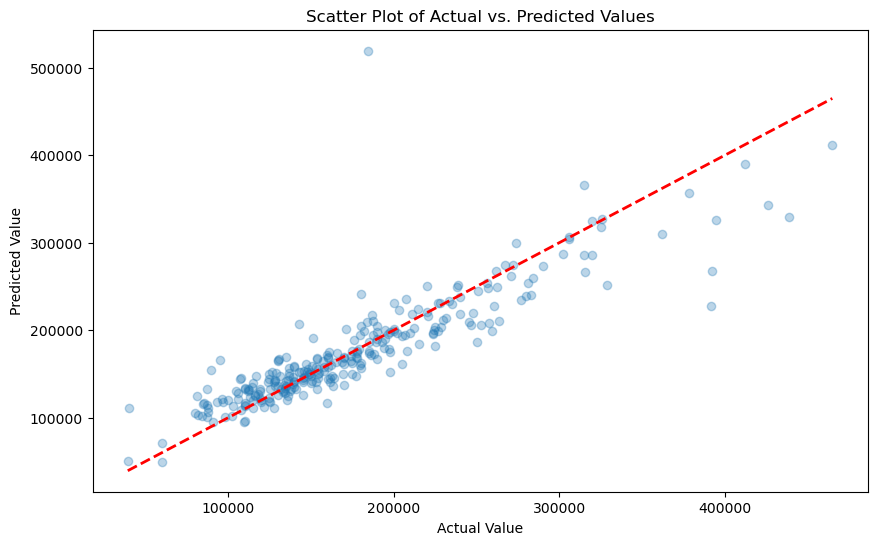

In [51]:
import matplotlib.pyplot as plt

# Assuming 'result' is a DataFrame with the actual targets ('Target') and the predicted values ('Predicted_Value')

# Scatter plot of Predicted vs. Actual values
plt.figure(figsize=(10, 6))
plt.scatter(result['Target'], result['Predicted_Value'], alpha=0.3)
plt.plot([result['Target'].min(), result['Target'].max()], [result['Target'].min(), result['Target'].max()], '--r', linewidth=2)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Scatter Plot of Actual vs. Predicted Values')
plt.show()


### Scatter Plot of Predicted vs. Actual Values

This plot displays each predicted value against its corresponding actual value.

- **Ideal Scenario**: In a perfect model, all points would lie on the diagonal line, indicating that predictions are exactly the same as the actual values.
- **Good Fit**: Points clustered around the diagonal line suggest a good fit; the closer they are to the line, the better the predictions.
- **Systematic Bias**: Systematic deviations above or below the diagonal line might indicate a bias in the predictions.
- **Variance**: A wide spread of points around the diagonal line suggests high variance and inconsistent prediction accuracy.


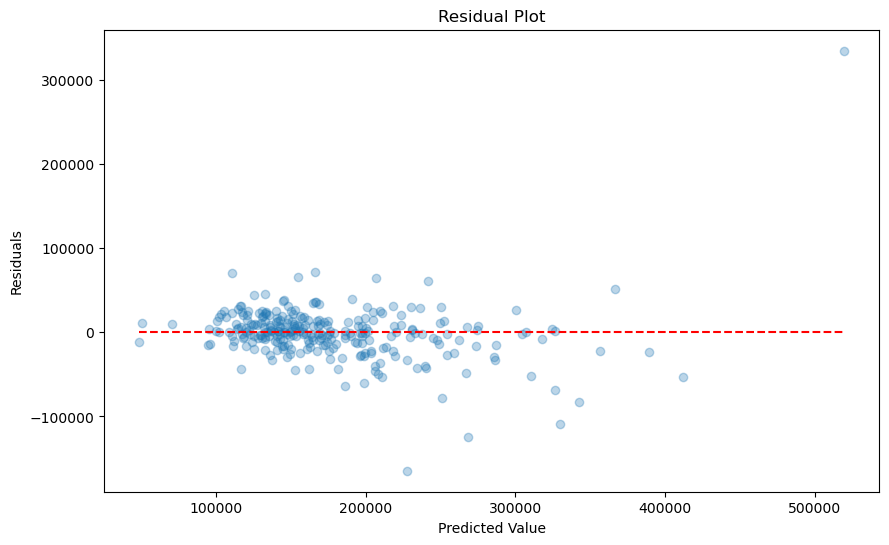

In [52]:
# Residual Plot
residuals = result['Predicted_Value'] - result['Target']
plt.figure(figsize=(10, 6))
plt.scatter(result['Predicted_Value'], residuals, alpha=0.3)
plt.hlines(y=0, xmin=result['Predicted_Value'].min(), xmax=result['Predicted_Value'].max(), colors='r', linestyles='--')
plt.xlabel('Predicted Value')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Residual Plot

The residual plot shows the residuals (the differences between actual and predicted values) against the predicted values.

- **Random Distribution**: Ideally, residuals should be randomly distributed around the horizontal line at zero, with no discernible pattern.
- **Patterns or Trends**: Structured patterns, such as curves or clustered groups, suggest that the model is not capturing some aspect of the data's structure.
- **Homoscedasticity**: The spread of residuals should be roughly constant across all levels of predicted values. A spread that increases or decreases with predicted value indicates heteroscedasticity.


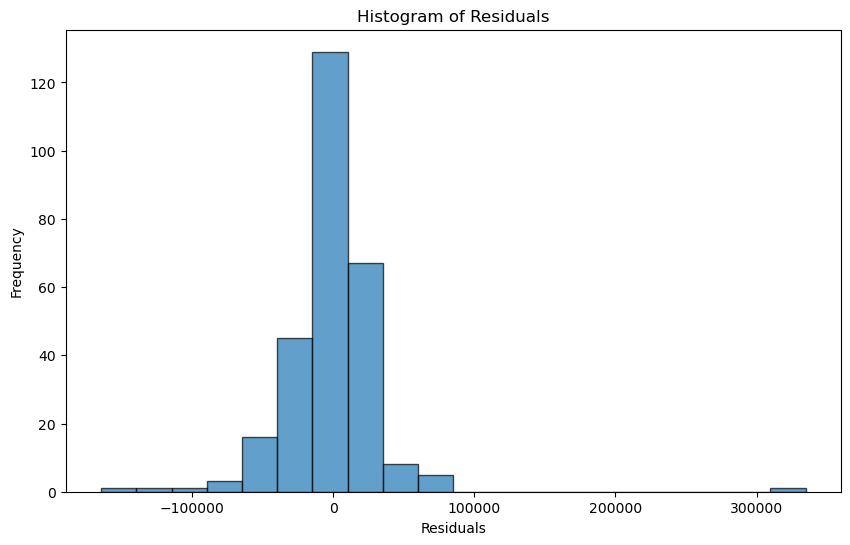

In [53]:
# Histogram of the Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

### Histogram of the Residuals

The histogram of residuals shows the frequency of each range of residual values.

- **Normal Distribution**: A well-fitting model should have residuals normally distributed around zero, indicated by a bell-shaped curve with the peak at zero.
- **Skewness**: A non-symmetrical histogram suggests systematic over or under-prediction.
- **Outliers**: Bars on the far left or right indicate the presence of outliers where the model's predictions were significantly off.


## SHAP